### Library Setup

In [1]:
import os
import yfinance as yf
from vnstock import Vnstock
from typing import Dict, List, Tuple, Type, Union, Callable, Optional, Any

from gymnasium import spaces
import gymnasium as gym

import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.font_manager import FontProperties

from stable_baselines3 import SAC, PPO, A2C, TD3
from sb3_contrib import RecurrentPPO, TRPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

import warnings

warnings.filterwarnings('ignore')

# Clear Cell output if your Dark Mode Client bugs

### Data Preparing

In [2]:
def fetch_stock_data(vn_stock_list: List[str], global_stock_list: List[str], starting: str, ending: str) -> pd.DataFrame:
    # Create a full date range including weekends
    date_range = pd.date_range(start=starting, end=ending, freq='D')
    stock_data_dict = {}
    
    print(f"Fetching {len(vn_stock_list)} Vietnamese stock data...")
    for stock in vn_stock_list:
        try:
            data = Vnstock().stock(symbol=stock, source='VCI').quote.history(
                start=starting, end=ending
            )
            # Reset index and rename 'time' to 'date'
            data.reset_index(inplace=True)
            data.rename(columns={'time': 'date'}, inplace=True)
            # Convert 'date' to datetime and set as index
            data['date'] = pd.to_datetime(data['date'])
            data.set_index('date', inplace=True)
            # Select relevant columns
            data = data[['open', 'high', 'low', 'close']]
            
            # Create a new DataFrame with all dates, but keep NaN values for now
            full_data = pd.DataFrame(index=date_range, columns=data.columns)
            full_data.loc[data.index] = data  # Add existing data
            
            # Fill gap days with evenly distributed price changes
            full_data = fill_price_gaps_evenly(full_data)
            
            # Create multi-index with stock symbol and metrics
            full_data.columns = pd.MultiIndex.from_product([[stock], full_data.columns], names=['Stock', 'Metric'])
            stock_data_dict[stock] = full_data
        except Exception as e:
            print(f"Error fetching data for {stock}: {e}")
            continue
    
    print(f"Fetching {len(global_stock_list)} Global stock data...")
    for stock in global_stock_list:
        try:
            data = yf.download(stock, start=starting, end=ending)
            # Ensure index is datetime
            data.index = pd.to_datetime(data.index)
            
            # Select and rename columns to match Vietnamese stock format
            data = data[['Open', 'High', 'Low', 'Close']]
            data.columns = ['open', 'high', 'low', 'close']
            
            price_columns = ['open', 'high', 'low', 'close']
            data[price_columns] = data[price_columns] * 25.5  # Multiply by 25.5 for USD to VND conversion
            
            # Limit to 2 decimal places
            data[price_columns] = data[price_columns].round(2)
            
            # Create a new DataFrame with all dates, but keep NaN values for now
            full_data = pd.DataFrame(index=date_range, columns=data.columns)
            full_data.loc[data.index] = data  # Add existing data
            
            # Fill gap days with evenly distributed price changes
            full_data = fill_price_gaps_evenly(full_data)
            
            # Create multi-index with stock symbol and metrics
            full_data.columns = pd.MultiIndex.from_product([[stock], full_data.columns], names=['Stock', 'Metric'])
            stock_data_dict[stock] = full_data
        except Exception as e:
            print(f"Error fetching data for {stock}: {e}")
            continue
    
    # Concatenate all stock data horizontally
    if stock_data_dict:
        combined_data = pd.concat(stock_data_dict.values(), axis=1)
        
        # Set title for all columns
        combined_data.columns = pd.MultiIndex.from_tuples(combined_data.columns, names=['Stock', 'Metric'])
        
        # Sort columns by stock name
        combined_data = combined_data.sort_index(axis=1, level='Stock')
        
        # Check for any remaining NaN values
        null_counts = combined_data.isnull().sum()
        if null_counts.sum() > 0:
            print("Warning: There are still NaN values in the data:")
        
        return combined_data
    else:
        raise ValueError("No stock data was successfully fetched.")


def fill_price_gaps_evenly(df):
    """
    Fill gaps in price data by evenly distributing the price change across missing days.
    
    For each gap:
    1. Find the last value before the gap and the first value after the gap
    2. Calculate the total change for each metric (open, high, low, close)
    3. Distribute this change evenly across the missing days
    """
    result = df.copy()
    
    # Loop through each column (open, high, low, close)
    for col_name in result.columns:
        # Find sequences of NaN values
        is_nan = result[col_name].isna()
        
        if not is_nan.any():
            continue  # Skip if no NaN values in this column
        
        # Find the start and end indices of each gap
        gap_starts = []
        gap_ends = []
        
        in_gap = False
        for i in range(len(is_nan)):
            if is_nan.iloc[i] and not in_gap:
                gap_starts.append(i)
                in_gap = True
            elif not is_nan.iloc[i] and in_gap:
                gap_ends.append(i)
                in_gap = False
        
        # Handle the case where the gap extends to the end of the dataframe
        if len(gap_starts) > len(gap_ends):
            gap_ends.append(len(is_nan))
        
        # Process each gap
        for start_idx, end_idx in zip(gap_starts, gap_ends):
            # Skip gaps at the beginning or end where we can't calculate a gradient
            if start_idx == 0 or end_idx == len(result):
                continue
            
            # Get values before and after the gap
            start_date = result.index[start_idx - 1]
            end_date = result.index[end_idx]
            
            start_value = result.loc[start_date, col_name]
            end_value = result.loc[end_date, col_name]
            
            # Calculate the total price change and the change per day
            total_change = end_value - start_value
            gap_length = end_idx - start_idx
            change_per_day = total_change / (gap_length + 1)  # Include the end point in calculation
            
            # Fill gap days with evenly distributed price changes
            for i in range(gap_length):
                gap_date = result.index[start_idx + i]
                gap_value = start_value + change_per_day * (i + 1)
                result.loc[gap_date, col_name] = round(gap_value, 2)
    
    # Handle any remaining NaN values at the beginning or end
    result = result.ffill().bfill()
    
    return result

In [3]:
def merge_data_sources(
    data_frames: List[pd.DataFrame],
    output_file: str = None,
    country_to_stocks: Dict[str, List[str]] = None,
    news_sentiment_data: pd.DataFrame = None
) -> pd.DataFrame:
    """
    Merge stock data with economic indicators and news sentiment where applicable.
    """
    if len(data_frames) != 2:
        raise ValueError("Expected exactly two DataFrames (stock_data and economic_data)")
    
    stock_data, econ_data = data_frames
    
    # Create reverse mapping from stock to country
    stock_to_country = {}
    for country, stocks in country_to_stocks.items():
        for stock in stocks:
            stock_to_country[stock] = country
    
    # Find union of all indices to ensure complete date coverage
    common_index = stock_data.index.union(econ_data.index)
    
    # If news sentiment data is provided, include its dates in the common index
    if news_sentiment_data is not None:
        # Convert datetime column to datetime index if it's not already
        if not isinstance(news_sentiment_data.index, pd.DatetimeIndex):
            news_sentiment_data = news_sentiment_data.set_index('datetime')
        common_index = common_index.union(news_sentiment_data.index)
    
    # Reindex stock data to common index
    stock_data = stock_data.reindex(common_index)
    
    # Reindex economic data to common index
    econ_data = econ_data.reindex(common_index)
    
    # Create a new DataFrame to hold the combined data
    combined_data = stock_data.copy()
    
    # For each stock in the stock data
    for stock in stock_data.columns.levels[0]:
        if stock in stock_to_country:
            country = stock_to_country[stock]
            
            # Get economic indicators for this country
            if country in econ_data.columns.levels[0]:
                for indicator in econ_data[country].columns:
                    # Add the economic indicator to this stock
                    # Format: indicator_country (lowercase)
                    indicator_name = f"{indicator.lower()}"
                    combined_data[(stock, indicator_name)] = econ_data[(country, indicator)]
            
            # Add news sentiment if available
            if news_sentiment_data is not None:
                # Filter news sentiment for this stock
                stock_sentiment = news_sentiment_data[news_sentiment_data['ticker'] == stock]
                
                if not stock_sentiment.empty:
                    # Create a Series with the sentiment score
                    sentiment_series = stock_sentiment['sentiment_score']
                    
                    # If the index is not already a DatetimeIndex, convert it
                    if not isinstance(sentiment_series.index, pd.DatetimeIndex):
                        sentiment_series.index = pd.to_datetime(sentiment_series.index)
                    
                    # Reindex to match the combined data index
                    sentiment_series = sentiment_series.reindex(common_index)
                    
                    # Add to the combined data
                    combined_data[(stock, 'sentiment_score')] = sentiment_series
    
    # Ensure all column names are consistently formatted as MultiIndex
    combined_data.columns = pd.MultiIndex.from_tuples(
        [(col[0], col[1]) for col in combined_data.columns],
        names=['Stock', 'Metric']
    )
    
    # Sort columns for better organization
    combined_data = combined_data.sort_index(axis=1, level=['Stock', 'Metric'])
    
    # Check for any NaN values
    null_counts = combined_data.isnull().sum()
    if null_counts.sum() > 0:
        print("Warning: There are still NaN values in the combined data:")
        combined_data = combined_data.ffill().bfill()
    
    if output_file:
        try:
            combined_data.to_csv(output_file, index=True)
            print(f"Data saved to {output_file}")
        except Exception as e:
            print(f"Error saving data to {output_file}: {e}")
    
    return combined_data

### Environment

In [4]:
class CustomLoggingCallback(BaseCallback):
    def __init__(self, verbose=0, log_interval=500, save_path="plots", filename="training_rewards.pdf"):
        super(CustomLoggingCallback, self).__init__(verbose)
        self.rewards = []
        self.steps = []
        self.log_interval = log_interval
        self.save_path = save_path
        self.filename = filename

        # Ensure the save directory exists
        os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        reward = self.locals['rewards'][0]
        step = self.num_timesteps

        self.rewards.append(reward)
        self.steps.append(step)

        if self.verbose > 0 and step % self.log_interval == 0:
            avg_reward = np.mean(self.rewards[-self.log_interval:])
            max_reward = np.max(self.rewards[-self.log_interval:])
            min_reward = np.min(self.rewards[-self.log_interval:])
            print(f"Step: {step}, Avg Reward: {avg_reward}, Max Reward: {max_reward}, Min Reward: {min_reward}")

        return True

    def _on_training_end(self) -> None:
        if self.verbose > 0:
            total_rewards = sum(self.rewards)
            print(f"Training finished. Total rewards: {total_rewards}")
            print(f"Total steps: {self.steps[-1]}")
            self.plot_training(self.rewards)

    def plot_training(self, rewards):
        sma = np.convolve(rewards, np.ones(50) / 50, mode='valid')

        plt.figure()
        plt.title("Training Rewards", fontsize=14, fontweight='bold')
        plt.plot(rewards, label='Raw Reward', color='#F6CE3B', alpha=1)
        plt.plot(sma, label='SMA 50', color='#385DAA')
        plt.xlabel("Step", fontsize=12, fontweight='bold')
        plt.ylabel("Rewards", fontsize=12, fontweight='bold')
        plt.legend()
        plt.tight_layout()
        plt.grid(True)

        # Save the plot as PDF
        filepath = os.path.join(self.save_path, self.filename)
        plt.savefig(filepath, format='pdf')

        plt.show()
        plt.clf()
        plt.close()

In [5]:
class TradingEnv(gym.Env):
    def __init__(
        self, 
        df: pd.DataFrame,
        window_size: int, 
        frame_bound: tuple,
        initial_balance: int, 
        max_shares: int,      
        trade_max: int = 100,   
        trade_fee_percent: float = 0.001,
        risk_free_rate: float = 0.01 / 252
    ):
        self.window_size = window_size
        self.frame_bound = frame_bound
        self.initial_balance = initial_balance
        self.max_shares = max_shares
        self.trade_max = trade_max
        self.trade_fee_percent = trade_fee_percent
        self.risk_free_rate = risk_free_rate
        
        self.df = self.add_technical_indicators(df)
        
        self.prices, self.signal_features = self._process_data()
        self.shape = (self.window_size, self.signal_features.shape[1])
        super().__init__()

        # Define action space - one action per stock
        self.action_space = spaces.Box(
            low=-1,
            high=1,
            shape=(len([stock for stock in df.columns.levels[0] if stock != 'GLD']),),
            dtype=np.float64
        )
        
        # Define observation space
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=self.shape,
            dtype=np.float64
        )
        
        # Episode state variables
        self._start_tick = None
        self._end_tick = None
        self._truncated = None
        self._current_tick = None
        self._last_trade_tick = None
        self._total_reward = None
        self._total_profit = None
        self._trade_count = None
        self.history = None
        
        # Trading statistics variables
        self._balance = None
        self._shares_held = None
        self._portfolio_value = None
        self._prev_portfolio_value = None
        self._last_action = None
        self._peak_portfolio_value = None
        self._transaction_cost = None
        self._step_transaction_cost = None 

        # Reward tracking variables
        self.min_reward = None
        self.max_reward = None
        self.daily_returns = []
        
        self.reset()
        
    def add_technical_indicators(self, df: pd.DataFrame):
        """
        Add technical indicators to the dataframe
        """
        for stock in df.columns.levels[0]:
            # Bollinger Bands
            df[(stock, 'BBUpper')], df[(stock, 'BBMiddle')], df[(stock, 'BBLower')] = talib.BBANDS(
                df[(stock, 'close')], timeperiod=20, nbdevup=2, nbdevdn=2
            )
            
            # MACD
            df[(stock, 'MACD')], df[(stock, 'MACDSignal')], df[(stock, 'MACDHist')] = talib.MACD(
                df[(stock, 'close')], fastperiod=12, slowperiod=26, signalperiod=9
            )
            
            # RSI - Relative Strength Index
            df[(stock, 'RSI')] = talib.RSI(
                df[(stock, 'close')], timeperiod=14
            )
            
            # ADX - Average Directional Index
            df[(stock, 'ADX')] = talib.ADX(
                df[(stock, 'high')], df[(stock, 'low')], df[(stock, 'close')], timeperiod=14
            )
            
            # Handle NaN values
            df.fillna(0, inplace=True)
        
        return df

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        if seed is not None:
            self.action_space.seed(int(self.np_random.uniform(0, seed)))

        # Reload processed data
        self.prices, self.signal_features = self._process_data()
        
        # Reset episode state variables
        self._start_tick = self.window_size
        self._end_tick = self.signal_features.shape[0] - 1
        self._truncated = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._total_reward = 0.0
        self._total_profit = 0.0
        self._trade_count = 0
        self.history = {}
        
        # Reset trading statistics
        self.daily_returns = []
        self.min_reward = float('inf')
        self.max_reward = float('-inf')
        self._balance = self.initial_balance
        self._shares_held = {stock: 0 for stock in self.df.columns.levels[0]}
        self._last_action = np.zeros(len(self.df.columns.levels[0]))
        self._transaction_cost = 0
        self._step_transaction_cost = 0
        
        # Initialize portfolio value
        self._portfolio_value = self._balance
        self._prev_portfolio_value = self._portfolio_value
        self._peak_portfolio_value = self._portfolio_value

        return self._get_observation(), self._get_info()
    
    def step(self, action):
        self._truncated = False
        self._current_tick += 1
        self._last_action = action
    
        if self._current_tick == self._end_tick:
            self._truncated = True

        # Update portfolio based on action
        self._update_profit(action)
        
        # Calculate reward
        step_reward = self._calculate_reward()
        self._total_reward += step_reward

        info = self._get_info()
        # Update trade tracking
        self._last_trade_tick = self._current_tick
        
        # Get observation and info
        observation = self._get_observation()
        
        # Update history
        self._update_history(info)
    
        return observation, step_reward, False, self._truncated, info
    
    def _get_info(self):
        """
        Return detailed information about current state
        """
        detailed_info = {
            'balance': self._balance,
            'shares_held': self._shares_held,
            'last_action': self._last_action,
            'portfolio_value': self._portfolio_value,
            'total_reward': self._total_reward,
            'total_profit': self._total_profit,
            'overall_transaction_cost': self._transaction_cost,
            'average_daily_return': np.mean(self.daily_returns) if self.daily_returns else 0, 
        }
        return detailed_info
    
    def _get_observation(self):
        """
        Return observation window of features
        """
        return self.signal_features[max(0, self._current_tick - self.window_size + 1):self._current_tick + 1]
    
    def _update_history(self, info):
        """
        Update history dictionary with info from current step
        """
        if not self.history:
            self.history = {key: [] for key in info.keys()}
        for key, value in info.items():
            self.history[key].append(value)

    def _process_data(self):
        """
        Process raw data into normalized features
        """
        raise NotImplementedError

    def _calculate_reward(self):
        """
        Calculate reward for current step
        """
        raise NotImplementedError

    def _update_profit(self, action):
        """
        Update portfolio based on action
        """
        raise NotImplementedError

In [6]:
class VnStockEnv(TradingEnv):
    def _process_data(self):
        """
        Feature processing
        """
        feature_columns = [
            'open', 'low', 'high', 'close', 
            'RSI', 'MACD', 'MACDSignal', 'MACDHist',
            'BBUpper', 'BBLower', 'BBMiddle', 'ADX',
            'gdp', 'cpi', 'unemployment_rate',
            'sentiment_score'
        ]
        prices = {}
        signal_features = pd.DataFrame()
        
        # Extract gold close price first
        if 'GLD' in self.df.columns.levels[0]:
            gold_close = self.df[('GLD', 'close')].iloc[self.frame_bound[0] - self.window_size:self.frame_bound[1]].values
            gold_close = np.nan_to_num(gold_close)
            
            # Add gold close price as a general feature (not stock-specific)
            signal_features['gold_close'] = gold_close
        
        # Process each stock
        for stock in self.df.columns.levels[0]:
            if stock == 'GLD':
                continue  # Skip gold as a stock, we're only using its price as reference
            
            # Get close prices for this stock
            prices_close = self.df[(stock, 'close')].to_numpy()
            prices_range = prices_close[self.frame_bound[0] - self.window_size : self.frame_bound[1]]
            prices[stock] = prices_range
            
            # Calculate stock-to-gold exchange rate
            if 'GLD' in self.df.columns.levels[0]:
                exchange_rate = np.zeros_like(prices_range)
                for i in range(len(prices_range)):
                    if gold_close[i] > 0:
                        # Calculate: (stock_price - gold_price) / gold_price
                        exchange_rate[i] = (prices_range[i] - gold_close[i]) / gold_close[i]
                
                # Add exchange rate as a stock-specific feature
                signal_features[(stock, 'gold_exchange_rate')] = exchange_rate
            
            # Process existing features
            for feature in feature_columns:
                if feature in self.df.columns.levels[1]:
                    data = self.df[(stock, feature)].iloc[self.frame_bound[0] - self.window_size:self.frame_bound[1]].values
                    data = np.nan_to_num(data)
                    signal_features[(stock, feature)] = data
                    
            # Add momentum indicators to help identify trends
            if 'close' in self.df.columns.levels[1]:
                close_prices = self.df[(stock, 'close')].values
                # Add price momentum (percent change over different periods)
                for period in [5, 10, 20]:
                    if len(close_prices) > period:
                        momentum = np.zeros_like(prices_range)
                        for i in range(len(prices_range)):
                            idx = self.frame_bound[0] - self.window_size + i
                            if idx >= period:
                                momentum[i] = (close_prices[idx] - close_prices[idx - period]) / close_prices[idx - period]
                        signal_features[(stock, f'momentum_{period}')] = momentum

        return prices, signal_features.values

    def _calculate_reward(self) -> float:
        """
        Calculate reward using a combination of portfolio return and penalties,
        optimized to focus on long-term portfolio growth with enhanced drawdown protection
        """
        # Base reward is the change in portfolio value minus transaction costs
        if self._prev_portfolio_value == 0:
            return 0
    
        # Calculate portfolio return
        portfolio_return = (self._portfolio_value - self._prev_portfolio_value) / self._prev_portfolio_value
        
        # Calculate annualized Sharpe ratio component if we have enough data
        sharpe_component = 0
        if len(self.daily_returns) > 5:
            # Use recent returns for Sharpe calculation
            recent_returns = self.daily_returns[-20:] if len(self.daily_returns) > 20 else self.daily_returns
            returns_mean = np.mean(recent_returns)
            returns_std = np.std(recent_returns) if np.std(recent_returns) > 0 else 1e-6
            sharpe_component = (returns_mean - self.risk_free_rate) / returns_std
            # Scale sharpe component to be in similar range as portfolio_return
            sharpe_component = 0.1 * sharpe_component
        
        # Calculate drawdown penalty - more severe for larger drawdowns
        drawdown = (self._peak_portfolio_value - self._portfolio_value) / self._peak_portfolio_value if self._peak_portfolio_value > 0 else 0
        
        # Enhanced drawdown penalty - cubic penalty for severe drawdowns
        drawdown_penalty = 0.3 * (drawdown ** 3) + 0.2 * (drawdown ** 2)
        
        # Add a recovery incentive - reward for reducing drawdown
        recovery_bonus = 0
        if len(self.daily_returns) > 1 and self.daily_returns[-1] > 0 and drawdown > 0:
            # Calculate previous drawdown
            prev_portfolio = self._portfolio_value - (self._portfolio_value * self.daily_returns[-1])
            prev_drawdown = (self._peak_portfolio_value - prev_portfolio) / self._peak_portfolio_value if self._peak_portfolio_value > 0 else 0
            
            # If drawdown is decreasing, add recovery bonus
            if drawdown < prev_drawdown:
                recovery_bonus = 0.2 * (prev_drawdown - drawdown)
        
        # Calculate transaction cost penalty - discourage excessive trading
        transaction_penalty = 2.0 * (self._step_transaction_cost / self._prev_portfolio_value) if self._prev_portfolio_value > 0 else 0
        
        # Calculate reward as return plus Sharpe component minus penalties
        reward = (2.5 * portfolio_return) + sharpe_component - drawdown_penalty + recovery_bonus - transaction_penalty - self.risk_free_rate
        
        # Add a bonus for reaching new portfolio highs - increased bonus
        if self._portfolio_value > self._peak_portfolio_value * 0.999:  # Within 0.1% of peak
            reward += 0.15  # Increased bonus for reaching new highs
        
        # Add a streak bonus for consistent positive returns
        streak_bonus = 0
        if len(self.daily_returns) >= 3:
            recent_returns = self.daily_returns[-3:]
            if all(ret > 0 for ret in recent_returns):
                streak_bonus = 0.1  # Bonus for 3+ consecutive positive days
            
        reward += streak_bonus
            
        # Penalize for holding too much cash (not being invested)
        cash_ratio = self._balance / self._portfolio_value if self._portfolio_value > 0 else 0
        if cash_ratio > 0.3:  # If more than 30% of portfolio is in cash
            reward -= 0.05 * (cash_ratio - 0.3)  # Small penalty for excessive cash
        
        # Add a volatility penalty to discourage high-risk strategies
        volatility_penalty = 0
        if len(self.daily_returns) > 10:
            recent_volatility = np.std(self.daily_returns[-10:])
            volatility_penalty = 0.1 * recent_volatility
            
        reward -= volatility_penalty
    
        # Update min and max rewards for normalization
        self.min_reward = min(self.min_reward, reward)
        self.max_reward = max(self.max_reward, reward)
        
        # Normalize reward to prevent extreme values
        normalized_reward = (reward - self.min_reward) / (self.max_reward - self.min_reward) if self.max_reward != self.min_reward else 0
        
        return normalized_reward

    def _update_profit(self, action):
        """
        Update portfolio based on action
        """
        # Store previous portfolio value for return calculation
        self._prev_portfolio_value = self._portfolio_value

        # Reset step transaction cost
        self._step_transaction_cost = 0

        # Get list of tradable stocks (excluding gold)
        tradable_stocks = [stock for stock in self.df.columns.levels[0] if stock != 'GLD']

        # Process each stock based on its corresponding action value
        for i, stock in enumerate(tradable_stocks):
            current_price = self.prices[stock][self._current_tick]

            if current_price <= 0:
                continue  # Skip invalid prices

            # Convert action from range [-1, 1] to actual shares to trade
            action_value = action[i]

            # Calculate target position based on action
            max_shares_to_trade = min(self.max_shares, self.trade_max)
            target_shares = int(action_value * max_shares_to_trade)
            shares_to_trade = target_shares - self._shares_held[stock]

            # Buy shares
            if shares_to_trade > 0:
                shares_to_buy = min(shares_to_trade, int(self._balance // current_price))
                cost = shares_to_buy * current_price
                transaction_fee = cost * self.trade_fee_percent
                total_cost = cost + transaction_fee

                if self._balance >= total_cost and shares_to_buy > 0:
                    self._balance -= total_cost
                    self._shares_held[stock] += shares_to_buy
                    self._step_transaction_cost += transaction_fee
                    self._transaction_cost += transaction_fee
                    self._trade_count += 1

            # Sell shares
            elif shares_to_trade < 0:
                shares_to_sell = min(abs(shares_to_trade), self._shares_held[stock])
                revenue = shares_to_sell * current_price
                transaction_fee = revenue * self.trade_fee_percent

                if shares_to_sell > 0:
                    self._balance += revenue - transaction_fee
                    self._shares_held[stock] -= shares_to_sell
                    self._step_transaction_cost += transaction_fee
                    self._transaction_cost += transaction_fee
                    self._trade_count += 1

        # Update portfolio value (excluding gold)
        self._portfolio_value = self._balance + sum(
            self._shares_held[stock] * self.prices[stock][self._current_tick]
            for stock in self.df.columns.levels[0]
            if stock != 'GLD'
        )

        # Update peak portfolio value for drawdown calculation
        self._peak_portfolio_value = max(self._peak_portfolio_value, self._portfolio_value)

        # Calculate daily return
        if self._prev_portfolio_value > 0:
            daily_return = (self._portfolio_value - self._prev_portfolio_value) / self._prev_portfolio_value
            self.daily_returns.append(daily_return)

        # Calculate profit
        self._total_profit = self._portfolio_value - self.initial_balance

### Training and Testing

In [7]:
# Hyperparameter for multiple algorithms
WINDOW_SIZE = [5, 10, 15, 20, 25]

HYPERPARAMS_PPO = [
    {
        "name": "PPO",
        "policy": "MlpPolicy",
        "learning_rate": 4e-3,
        "n_steps": 2048,
        "batch_size": 64,
        "n_epochs": 10,
        "gamma": 0.995,
        "ent_coef": 0.001,
        "clip_range": 0.2,
        "device": "cuda"
    }
]

HYPERPARAMS_A2C = [
    {
        "name": "A2C",
        "policy": "MlpPolicy",
        "learning_rate": 4e-3,
        "n_steps": 128,
        "gamma": 0.99,
        "max_grad_norm": 0.5,
        "device": "cuda"
    }
]

HYPERPARAMS_SAC = [
    {
        "name": "SAC",
        "policy": "MlpPolicy",
        "learning_rate": 4e-3,
        "buffer_size": 100000,
        "batch_size": 64,
        "gamma": 0.99,
        "tau": 0.005,
        "device": "cuda"
    }
]

HYPERPARAMS_RPPO = [
    {
        "name": "RPPO",
        "policy": "MlpLstmPolicy",
        "learning_rate": 4e-3,
        "n_steps": 512,
        "batch_size": 64,
        "gamma": 0.99,
        "clip_range": 0.2,
        "max_grad_norm": 0.5,
        "device": "cuda"
    }
]

HYPERPARAMS_TRPO = [
    {
        "name": "TRPO",
        "policy": "MlpPolicy",
        "learning_rate": 4e-3,
        "n_steps": 2048,
        "cg_damping": 0.1,
        "batch_size": 64,
        "gamma": 0.99,
        "target_kl": 0.01,
        "device": "cuda"
    }
]

HYPERPARAMS_TD3 = [
    {
        "name": "TD3",
        "policy": "MlpPolicy",
        "learning_rate": 4e-3,
        "buffer_size": 100000,
        "batch_size": 64,
        "gamma": 0.99,
        "tau": 0.005,
        "device": "cuda"
    }
]

In [8]:
def create_environment(data: pd.DataFrame, window_size: int, initial_balance: float, max_shares: int, trade_max: int) -> TradingEnv:
    """Create and configure trading environment"""
    # Set up environment parameters
    frame_bound = (window_size, len(data))

    # Create environment
    env = VnStockEnv(
        df=data,
        window_size=window_size,
        frame_bound=frame_bound,
        initial_balance=initial_balance,
        max_shares=max_shares,
        trade_max=trade_max
    )
    
    # Debugging
    # print("Testing environment...")
    # action = env.action_space.sample()
    # observation, _, _, _, _ = env.step(action)
    # print(f"Observation shape: {observation.shape}")
        
    return env

def train_model(model_class, params: dict, data: pd.DataFrame, initial_balance: float, max_shares:  int, trade_max: int, window_size: int, timesteps: int = 500000) -> str:
    """Train a model with specific parameters"""
    # Create environment
    env = create_environment(data, window_size, initial_balance, max_shares, trade_max)
    
    # Setup monitoring
    model_name = params.pop("name")
    os.makedirs(f"models/{model_name}/{window_size}", exist_ok = True)
    os.makedirs(f"logs/{model_name}/{window_size}", exist_ok = True)
    
    env = Monitor(env, f"logs/{model_name}/{window_size}")
    env = DummyVecEnv([lambda: env])
    
    # Create callback
    callback = CustomLoggingCallback(
        verbose = 1, 
        log_interval = 20000, 
        save_path = f"models/{model_name}/{window_size}", 
        filename = f"{model_name}_{window_size}_training.pdf"
    )
    
    # Create and train model
    model = model_class(**params, env = env, verbose = 0)
    model.learn(total_timesteps = timesteps, callback = callback)
    
    # Save model
    model_path = f"models/{model_name}/{model_name}_{window_size}.zip"
    model.save(model_path)
    
    params["name"] = model_name
    
    return model_path

def evaluate_model(model_path: str, model_class, data: pd.DataFrame, initial_balance: float, max_shares: int, trade_max: int, window_size: int) -> Tuple[List[float], List[float], List[float], List[float]]:
    """Evaluate a trained model on test data"""
    # Create test environment
    env = create_environment(data, window_size, initial_balance, max_shares, trade_max)
    env = Monitor(env, None)
    env = DummyVecEnv([lambda: env])
    
    # Load model
    model = model_class.load(model_path)
    
    # Run evaluation episodes
    obs = env.reset()
    truncated = False
    
    # Track performance metrics
    portfolio_values = []
    returns = []
    actions = []
    total_profit = []
    
    while not truncated:
        action, _ = model.predict(obs)
        obs, reward, truncated, info = env.step(action)
        
        for i in info:
            portfolio_values.append(i['portfolio_value'])
            returns.append(i['average_daily_return'])
            actions.append(i['last_action'])
            total_profit.append(i['total_profit'])
            
    performance_metrics = calculate_metrics(portfolio_values, returns, initial_balance)
            
    # Save results
    model_name = model_path.split('/')[-2]
    os.makedirs(f"logs/{model_name}/{window_size}", exist_ok=True)
    
    results_df = pd.DataFrame({
        'Trading Day': range(len(portfolio_values)),
        'Portfolio Value': portfolio_values,
        'Daily Return': returns,
        'Total Profit': total_profit
    })
    
    results_df.to_csv(f"logs/{model_name}/{window_size}/evaluation.csv", index=False)
    
    return {
        "portfolio_values": portfolio_values,
        "returns": returns,
        "actions": actions,
        "total_profit": total_profit,
        "performance_metrics": performance_metrics
    }

In [9]:
def calculate_metrics(portfolio_values: List[float], returns: List[float], initial_balance: float) -> Dict:
    """
    Calculate trading performance metrics
    """
    if not portfolio_values or not returns:
        return {
            "cumulative_return": 0,
            "max_drawdown": 0,
            "annual_return": 0,
            "sharpe_ratio": 0,
            "calmar_ratio": 0,
            "sortino_ratio": 0,
            "win_rate": 0
        }
    portfolio_values = np.array(portfolio_values)
    returns = np.array(returns)
    
    # Cumulative return
    cumulative_return = (portfolio_values[-1] - initial_balance) / initial_balance
    
    # Maximum drawdown
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = np.max(drawdown)
    
    # Annual return (assuming 252 trading days per year)
    n_days = len(portfolio_values)
    annual_return = ((1 + cumulative_return) ** (252 / n_days)) - 1
    
    # Risk-free rate
    risk_free_rate = 0.01
    
    # Sharpe ratio
    daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    excess_returns = daily_returns - (risk_free_rate / 252)  # Daily risk-free rate
    sharpe_ratio = np.sqrt(252) * np.mean(excess_returns) / np.std(excess_returns) if np.std(excess_returns) > 0 else 0
    
    # Calmar ratio
    calmar_ratio = annual_return / max_drawdown if max_drawdown > 0 else 0
    
    # Sortino ratio (using downside deviation)
    negative_returns = daily_returns[daily_returns < 0]
    downside_deviation = np.std(negative_returns) if len(negative_returns) > 0 else 0
    sortino_ratio = np.sqrt(252) * np.mean(excess_returns) / downside_deviation if downside_deviation > 0 else 0
    
    # Win rate
    win_count = np.sum(daily_returns > 0)
    total_trades = len(daily_returns)
    win_rate = win_count / total_trades if total_trades > 0 else 0
    
    return {
        "cumulative_return": cumulative_return,
        "max_drawdown": max_drawdown,
        "annual_return": annual_return,
        "sharpe_ratio": sharpe_ratio,
        "calmar_ratio": calmar_ratio,
        "sortino_ratio": sortino_ratio,
        "win_rate": win_rate
    }

In [10]:
def plot_portfolio_performance(
    results: Dict[str, Dict[str, Dict]], 
    save_path: str = "plots"
) -> None:
    """
    Plot portfolio performance visualizations organized by model with publication-quality styling
    
    Parameters:
    - results: Nested dictionary containing model results
    - save_path: Directory to save plots
    """
    os.makedirs(save_path, exist_ok=True)
    
    # Define a publication-friendly color palette (colorblind safe)
    # Using a more consistent and academic color scheme
    color_palette = {
        "PPO": {
            "5": "#1f77b4",    # Strong blue
            "10": "#ff7f0e",   # Safety orange
            "15": "#2ca02c",   # Green
            "20": "#d62728",   # Red
            "25": "#9467bd"    # Purple
        },
        "A2C": {
            "5": "#8c564b",    # Brown
            "10": "#e377c2",   # Pink
            "15": "#7f7f7f",   # Gray
            "20": "#bcbd22",   # Olive
            "25": "#17becf"    # Cyan
        },
        "RPPO": {
            "5": "#1a5f7a",    # Deep teal
            "10": "#c44e52",   # Coral red
            "15": "#55a868",   # Forest green
            "20": "#8172b3",   # Lavender
            "25": "#ccb974"    # Sand
        },
        "TRPO": {
            "5": "#4c78a8",    # Steel blue
            "10": "#f58518",   # Burnt orange
            "15": "#72b7b2",   # Aqua
            "20": "#e45756",   # Salmon
            "25": "#54a24b"    # Grass green
        },
        "SAC": {
            "5": "#b279a2",    # Mauve
            "10": "#ff9da7",   # Light coral
            "15": "#9ecae1",   # Light blue
            "20": "#f7b6d2",   # Light pink
            "25": "#dbdb8d"    # Light olive
        },
        "TD3": {
            "5": "#6b6ecf",    # Periwinkle
            "10": "#b5cf6b",   # Lime
            "15": "#ad494a",   # Dark red
            "20": "#8c6d31",   # Bronze
            "25": "#7b4173"    # Plum
        }
    }

    # Define line styles for better differentiation in grayscale printing
    line_styles = {
        "5": "-",         # Solid
        "10": "--",       # Dashed
        "15": "-.",       # Dash-dot
        "20": ":",        # Dotted
        "25": (0, (3, 1, 1, 1))  # Complex dash-dot-dot
    }
    
    marker_styles = {
        "5": "o",      # Circle
        "10": "s",     # Square
        "15": "^",     # Triangle
        "20": "d",     # Diamond
        "25": "P"      # Plus (filled)
    }
    
    # Set professional typography for publication
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Computer Modern Roman', 'Times New Roman'],
        'font.size': 11,
        'axes.labelsize': 12,
        'axes.titlesize': 13,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.titlesize': 14,
        'axes.grid': True,
        'grid.alpha': 0.3,
        'axes.axisbelow': True  # Place grid behind plot elements
    })

    # Background and grid colors for better contrast
    bg_color = '#f8f9fa'
    grid_color = '#e6e6e6'

    # Calculate performance for sorting
    model_performance = []
    for model_name, window_sizes in results.items():
        for window_size, metrics in window_sizes.items():
            perf_metrics = metrics["performance_metrics"]
            performance_score = perf_metrics["sharpe_ratio"] * (1 + perf_metrics["cumulative_return"])
            model_performance.append((model_name, window_size, performance_score))
    
    model_performance.sort(key=lambda x: x[2], reverse=True)
    
    # Create individual plots for each model
    for model_name in results.keys():
        model_path = os.path.join(save_path, model_name)
        os.makedirs(model_path, exist_ok=True)
        
        # 1. Cumulative Returns Plot with academic styling
        fig, ax = plt.subplots(figsize=(7, 5), dpi=300)
        
        fig.patch.set_facecolor('white')
        ax.set_facecolor(bg_color)
        ax.grid(True, color=grid_color, linestyle='-', linewidth=0.5)
        
        for window_size in results[model_name].keys():
            # Get data
            portfolio_values = np.array(results[model_name][window_size]["portfolio_values"])
            initial_value = portfolio_values[0]
            cumulative_returns = (portfolio_values / initial_value) - 1
            
            # Get styling elements
            color = color_palette[model_name][str(window_size)]
            linestyle = line_styles[str(window_size)]
            marker = marker_styles[str(window_size)]
            
            # Plot with markers at regular intervals for better readability
            label = f"Window Size: {window_size}"
            ax.plot(cumulative_returns, label=label, 
                    linewidth=1.5, 
                    color=color,
                    linestyle=linestyle,
                    marker=marker,
                    markevery=max(1, len(cumulative_returns) // 20),  # Show ~20 markers
                    markersize=4)
        
        ax.set_title(f'{model_name} Model - Cumulative Returns', fontweight='bold')
        ax.set_xlabel('Trading Days')
        ax.set_ylabel('Cumulative Return')
        
        # Add percentage formatting to y-axis
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        
        # Add horizontal line at y=0
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
        
        # Improved legend with nice styling
        ax.legend(loc='best', frameon=True, fancybox=False, 
                  edgecolor='black', facecolor='white', framealpha=0.9,
                  ncol=2, columnspacing=1.0)
        
        # Set spine colors and width
        for spine in ax.spines.values():
            spine.set_color('black')
            spine.set_linewidth(0.5)
        
        plt.tight_layout()
        plt.savefig(f"{model_path}/cumulative_returns.png", dpi=300, bbox_inches='tight')
        plt.savefig(f"{model_path}/cumulative_returns.pdf", format='pdf', bbox_inches='tight')
        plt.close()
        
        # 2. Drawdown Analysis with academic styling
        fig, ax = plt.subplots(figsize=(7, 5), dpi=300)
        
        fig.patch.set_facecolor('white')
        ax.set_facecolor(bg_color)
        ax.grid(True, color=grid_color, linestyle='-', linewidth=0.5)
        
        for window_size in results[model_name].keys():
            # Get data
            portfolio_values = np.array(results[model_name][window_size]["portfolio_values"])
            peak = np.maximum.accumulate(portfolio_values)
            drawdown = (peak - portfolio_values) / peak
            
            # Get styling elements
            color = color_palette[model_name][str(window_size)]
            linestyle = line_styles[str(window_size)]
            marker = marker_styles[str(window_size)]
            
            # Plot with markers at regular intervals
            label = f"Window Size: {window_size}"
            ax.plot(drawdown, label=label, 
                    linewidth=1.5, 
                    color=color,
                    linestyle=linestyle,
                    marker=marker,
                    markevery=max(1, len(drawdown) // 20),  # Show ~20 markers
                    markersize=4)
        
        ax.set_title(f'{model_name} Model - Drawdown Analysis', fontweight='bold')
        ax.set_xlabel('Trading Days')
        ax.set_ylabel('Drawdown')
        
        # Add percentage formatting to y-axis
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        
        # Improved legend
        ax.legend(loc='best', frameon=True, fancybox=False, 
                  edgecolor='black', facecolor='white', framealpha=0.9,
                  ncol=2, columnspacing=1.0)
        
        # Set spine colors and width
        for spine in ax.spines.values():
            spine.set_color('black')
            spine.set_linewidth(0.5)
        
        plt.tight_layout()
        plt.savefig(f"{model_path}/drawdown.png", dpi=300, bbox_inches='tight')
        plt.savefig(f"{model_path}/drawdown.pdf", format='pdf', bbox_inches='tight')
        plt.close()
        
        # 3. Performance Metrics Heatmap with publication styling
        metrics_df = []
        
        for window_size, metrics in results[model_name].items():
            perf_metrics = metrics["performance_metrics"]
            row = {
                "Window Size": window_size,
                "Cumulative Return": perf_metrics["cumulative_return"],
                "Max Drawdown": perf_metrics["max_drawdown"],
                "Annual Return": perf_metrics["annual_return"],
                "Sharpe Ratio": perf_metrics["sharpe_ratio"],
                "Calmar Ratio": perf_metrics["calmar_ratio"],
                "Sortino Ratio": perf_metrics["sortino_ratio"],
                "Win Rate": perf_metrics["win_rate"]
            }
            metrics_df.append(row)
        
        metrics_df = pd.DataFrame(metrics_df)
        metrics_df = metrics_df.sort_values(by="Window Size", key=lambda x: x.astype(int))
        metrics_df.set_index("Window Size", inplace=True)
        
        # Create heatmap with professional styling
        fig, ax = plt.subplots(figsize=(8, len(metrics_df) * 0.6 + 1), dpi=300)
        
        # Use research-appropriate colormap
        cmap = plt.cm.RdBu_r  # Red-White-Blue reversed (red = higher/better)
        
        # Format the data for better display
        # Create a formatter function for annotations
        def value_formatter(val, metric):
            if metric in ["Cumulative Return", "Max Drawdown", "Annual Return", "Win Rate"]:
                return f"{val:.2%}"
            else:
                return f"{val:.3f}"
        
        # Create formatted annotation array
        annot_array = np.empty_like(metrics_df.values, dtype=object)
        for i, col in enumerate(metrics_df.columns):
            for j, val in enumerate(metrics_df[col].values):
                annot_array[j, i] = value_formatter(val, col)
        
        # Set normalization center point to zero for diverging metrics
        vmin = min(0, metrics_df.min().min())
        vmax = max(0, metrics_df.max().max())
        
        # Create the heatmap with improved styling
        sns.heatmap(metrics_df, annot=annot_array, cmap=cmap, fmt="", 
                   linewidths=0.5, cbar=True, center=0,
                   vmin=vmin, vmax=vmax,
                   ax=ax, 
                   annot_kws={"size": 9, "weight": "normal"},
                   cbar_kws={"shrink": 0.8, "label": "Value"})
        
        # Better title with model name
        ax.set_title(f'{model_name} Model - Performance Metrics by Window Size', fontweight='bold', pad=10)
        
        # Rotate column labels for readability
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()
        plt.savefig(f"{model_path}/performance_metrics_heatmap.png", dpi=300, bbox_inches='tight')
        plt.savefig(f"{model_path}/performance_metrics_heatmap.pdf", format='pdf', bbox_inches='tight')
        plt.close()
    
    # 4. Performance Metrics Table for all models
    metrics_df = []

    for model_name, window_sizes in results.items():
        for window_size, metrics in window_sizes.items():
            perf_metrics = metrics["performance_metrics"]
            row = {
                "Model": f"{model_name}_{window_size}",  # Fixed to include underscore
                "Cumulative Return": perf_metrics["cumulative_return"],
                "Max Drawdown": perf_metrics["max_drawdown"],
                "Annual Return": perf_metrics["annual_return"],
                "Sharpe Ratio": perf_metrics["sharpe_ratio"],
                "Calmar Ratio": perf_metrics["calmar_ratio"],
                "Sortino Ratio": perf_metrics["sortino_ratio"],
                "Win Rate": perf_metrics["win_rate"]
            }
            metrics_df.append(row)

    metrics_df = pd.DataFrame(metrics_df)

    # Create table figure
    fig, ax = plt.subplots(figsize=(10, len(metrics_df) * 0.4 + 1), dpi=300)
    ax.axis('off')

    # Create table with darker edges
    table = ax.table(
        cellText=metrics_df.iloc[:, 1:].values,
        rowLabels=metrics_df['Model'],
        colLabels=metrics_df.columns[1:],
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )

    # Style table with improved visibility
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    
    # Find max values for each column to highlight
    max_values = {}
    for col in metrics_df.columns[1:]:
        max_values[col] = metrics_df[col].max()

    # Enhanced styling with alternating row colors and darker borders
    for (row, col), cell in table.get_celld().items():
        # Make all cell edges darker and thicker
        cell.set_edgecolor('#333333')
        cell.set_linewidth(1.5)
        
        if row == 0:  # Header
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            cell.set_facecolor('#c0c0c0')  # Darker header background
        elif col == -1:  # Row labels
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            cell.set_facecolor('#c0c0c0')  # Darker row labels background
        else:  # Data cells
            # Alternating row colors for better readability
            if row % 2 == 0:
                cell.set_facecolor('#f2f2f2')  # Light grey for even rows
            else:
                cell.set_facecolor('#ffffff')  # White for odd rows
                
        if row > 0 and col >= 0:  # Format numbers
            text = cell.get_text().get_text()
            try:
                val = float(text)
                # Format based on column type
                if col == 0:  # Cumulative Return
                    formatted_text = f"{val:.2%}"
                    # Highlight max value
                    if val == max_values["Cumulative Return"]:
                        cell.get_text().set_weight('bold')
                        cell.set_facecolor('#d9d9d9')  # Darker background for max value
                    cell.get_text().set_text(formatted_text)
                elif col == 1:  # Max Drawdown
                    formatted_text = f"{val:.2%}"
                    # For drawdown, the smallest (least negative) is best
                    if val == max_values["Max Drawdown"]:
                        cell.get_text().set_weight('bold')
                        cell.set_facecolor('#d9d9d9')
                    cell.get_text().set_text(formatted_text)
                elif col == 2:  # Annual Return
                    formatted_text = f"{val:.2%}"
                    if val == max_values["Annual Return"]:
                        cell.get_text().set_weight('bold')
                        cell.set_facecolor('#d9d9d9')
                    cell.get_text().set_text(formatted_text)
                elif col == 6:  # Win Rate
                    formatted_text = f"{val:.2%}"
                    if val == max_values["Win Rate"]:
                        cell.get_text().set_weight('bold')
                        cell.set_facecolor('#d9d9d9')
                    cell.get_text().set_text(formatted_text)
                else:  # Other ratios
                    formatted_text = f"{val:.3f}"
                    # Check if this is the max value for this column
                    col_name = metrics_df.columns[col+1]  # +1 because we skipped the first column
                    if val == max_values[col_name]:
                        cell.get_text().set_weight('bold')
                        cell.set_facecolor('#d9d9d9')
                    cell.get_text().set_text(formatted_text)
            except ValueError:
                pass

    plt.title('Performance Metrics Comparison - All Models', fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(f"{save_path}/performance_metrics_table.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_path}/performance_metrics_table.pdf", format='pdf', bbox_inches='tight')
    plt.close()
    
    # 5. Radar Chart for Top Models
    # Create a radar chart comparing the top 5 models by performance score
    metrics_for_radar = ["Sharpe Ratio", "Sortino Ratio", "Calmar Ratio", "Annual Return", "Win Rate"]
    
    # Get the top 5 models by performance score (using the sorted model_performance list)
    top_5_models = model_performance[:5]
    top_model_names = [f"{model}_{window}" for model, window, _ in top_5_models]
    
    # Create a DataFrame for the radar chart with only the top 5 models
    top_models = metrics_df[metrics_df['Model'].isin(top_model_names)].set_index('Model')
    
    # Normalize the data for radar chart
    radar_data = top_models[metrics_for_radar].copy()
    for col in radar_data.columns:
        if col in ["Max Drawdown"]:  # For metrics where lower is better
            radar_data[col] = (radar_data[col].max() - radar_data[col]) / (radar_data[col].max() - radar_data[col].min())
        else:  # For metrics where higher is better
            radar_data[col] = (radar_data[col] - radar_data[col].min()) / (radar_data[col].max() - radar_data[col].min())
    
    # Number of variables
    N = len(metrics_for_radar)
    
    # Create angles for each metric (divide the plot into equal parts)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Create the radar chart with academic styling
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True), dpi=300)
    fig.patch.set_facecolor('white')
    
    # Add background grid with light color
    ax.set_facecolor(bg_color)
    ax.grid(True, color=grid_color, linestyle='-', linewidth=0.5, alpha=0.7)
    
    # Extract model components for coloring and styling
    model_components = [model.split('_') for model in top_models.index]
    model_types = [comp[0] for comp in model_components]
    windows = [comp[1] for comp in model_components]
    
    # Plot each model
    for i, model in enumerate(top_models.index):
        model_type = model.split('_')[0]
        window = model.split('_')[1]
        
        # Get data for this model
        values = radar_data.loc[model].values.tolist()
        values += values[:1]  # Close the loop
        
        # Get color and line style
        color = color_palette[model_type][window]
        linestyle = line_styles[window]
        marker = marker_styles[window]
        
        # Plot the model data
        ax.plot(angles, values, linewidth=2, linestyle=linestyle, color=color, 
                marker=marker, markersize=6, label=model)
        ax.fill(angles, values, color=color, alpha=0.1)
    
    # Set the labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics_for_radar, fontsize=10)
    
    # Remove radial labels and set y-ticks to be inside the plot
    ax.set_yticklabels([])
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_rlabel_position(180 / N)  # Move radial labels away from the plotted line
    
    # Add subtle circular gridlines
    for ytick in [0.25, 0.5, 0.75, 1.0]:
        ax.text(np.pi/N, ytick, f"{ytick:.2f}", ha='center', va='center', fontsize=8, color='gray')
    
    # Add legend with better positioning and styling
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), frameon=True,
               fancybox=False, edgecolor='black', facecolor='white')
    
    plt.title('Top Models - Comparative Performance', size=14, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.savefig(f"{save_path}/top_models_radar_chart.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_path}/top_models_radar_chart.pdf", format='pdf', bbox_inches='tight')
    plt.close()
    
    # 6. Bar Charts for Key Metrics across top models
    key_comparison_metrics = ["Sharpe Ratio", "Sortino Ratio", "Calmar Ratio"]
    
    fig, axes = plt.subplots(len(key_comparison_metrics), 1, figsize=(8, 9), sharex=True, dpi=300)
    fig.patch.set_facecolor('white')
    
    for i, metric in enumerate(key_comparison_metrics):
        ax = axes[i]
        ax.set_facecolor(bg_color)
        ax.grid(True, color=grid_color, linestyle='-', linewidth=0.5, axis='y')
        
        # Use the same top models from the radar chart
        model_components = [model.split('_') for model in top_model_names]
        model_types = [comp[0] for comp in model_components]
        windows = [comp[1] for comp in model_components]
        
        # Get data for this metric
        metric_values = top_models[metric].values
        
        # Create bars with custom colors based on model type and window size
        bars = ax.bar(top_models.index, metric_values)
        
        # Color each bar according to its model type
        for j, bar in enumerate(bars):
            model_type = model_types[j]
            window = windows[j]
            bar.set_color(color_palette[model_type][window])
            bar.set_edgecolor('black')
            bar.set_linewidth(0.5)
        
        # Add value labels on top of bars
        for j, v in enumerate(metric_values):
            ax.text(j, v + 0.02 * max(metric_values), f"{v:.3f}", 
                    ha='center', va='bottom', fontsize=9, fontweight='normal')
        
        # Set title and labels
        ax.set_title(f'{metric}', fontweight='bold')
        if i == len(key_comparison_metrics) - 1:
            ax.set_xlabel('Model')
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Set spine colors and width
        for spine in ['bottom', 'left']:
            ax.spines[spine].set_color('black')
            ax.spines[spine].set_linewidth(0.5)
    
    plt.tight_layout()
    plt.savefig(f"{save_path}/top_models_metrics_comparison.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_path}/top_models_metrics_comparison.pdf", format='pdf', bbox_inches='tight')
    plt.close()
    
    # 7. Aggregate window size performance analysis
    # Create a composite DataFrame that aggregates performance by window size
    window_analysis = []
    
    for window_size in ["5", "10", "15", "20", "25"]:
        window_metrics = []
        for model_name, win_sizes in results.items():
            if window_size in win_sizes:
                metrics = win_sizes[window_size]["performance_metrics"]
                window_metrics.append({
                    "model": model_name,
                    "sharpe": metrics["sharpe_ratio"],
                    "sortino": metrics["sortino_ratio"],
                    "calmar": metrics["calmar_ratio"],
                    "return": metrics["cumulative_return"],
                    "drawdown": metrics["max_drawdown"]
                })
        
        if window_metrics:
            # Calculate averages
            avg_metrics = {
                "Window Size": window_size,
                "Average Sharpe": np.mean([m["sharpe"] for m in window_metrics]),
                "Average Sortino": np.mean([m["sortino"] for m in window_metrics]),
                "Average Calmar": np.mean([m["calmar"] for m in window_metrics]),
                "Average Return": np.mean([m["return"] for m in window_metrics]),
                "Average Drawdown": np.mean([m["drawdown"] for m in window_metrics]),
                "Best Model": max(window_metrics, key=lambda x: x["sharpe"])["model"]
            }
            window_analysis.append(avg_metrics)
    
    window_df = pd.DataFrame(window_analysis)
    
    if not window_df.empty:
        # Plot window size comparison
        fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
        fig.patch.set_facecolor('white')
        ax.set_facecolor(bg_color)
        
        # Create grouped bar chart
        bar_width = 0.15
        index = np.arange(len(window_df))
        
        metrics_to_plot = [
            ("Average Sharpe", "#4575b4", "Avg. Sharpe Ratio"),
            ("Average Sortino", "#91bfdb", "Avg. Sortino Ratio"),
            ("Average Calmar", "#fc8d59", "Avg. Calmar Ratio")
        ]
        
        # Plot bars
        for i, (column, color, label) in enumerate(metrics_to_plot):
            offset = (i - len(metrics_to_plot)/2 + 0.5) * bar_width
            bars = ax.bar(index + offset, window_df[column], bar_width, 
                        color=color, edgecolor='black', linewidth=0.5, 
                        label=label)
            
            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                        f'{height:.2f}', ha='center', va='bottom', fontsize=8)
        
        # Customize plot
        ax.set_xlabel('Window Size')
        ax.set_ylabel('Ratio Value')
        ax.set_title('Performance by Window Size', fontweight='bold')
        ax.set_xticks(index)
        ax.set_xticklabels(window_df['Window Size'])
        ax.legend(loc='upper left')
        
        # Add grid
        ax.grid(True, linestyle='--', axis='y', alpha=0.7)
        
        # Set spine colors
        for spine in ax.spines.values():
            spine.set_color('black')
            spine.set_linewidth(0.5)
            
        # Add annotations for best model
        for i, row in enumerate(window_df.itertuples()):
            ax.annotate(f"Best: {row.Best_Model}", 
                        (i, 0.1),
                        ha='center', va='bottom',
                        fontsize=8, style='italic',
                        rotation=90)
        
        plt.tight_layout()
        plt.savefig(f"{save_path}/window_size_analysis.png", dpi=300, bbox_inches='tight')
        plt.savefig(f"{save_path}/window_size_analysis.pdf", format='pdf', bbox_inches='tight')
        plt.close()
    
    # Return a summary text that could be used in a research paper
    performance_summary = f"Analysis completed. Visualizations saved to {save_path}/."
    return print(performance_summary)

In [11]:
def generate_results_dashboard(results: Dict[str, Dict[str, Dict]], save_path: str = "plots") -> None:
    """
    Generate a comprehensive trading performance dashboard with research-friendly visualization
    
    Parameters:
    - results: Nested dictionary containing model results
    - save_path: Directory to save plots
    """
    os.makedirs(save_path, exist_ok=True)
    
    # Set up professional typography for academic publication
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Computer Modern Roman', 'Times New Roman'],
        'font.size': 10,
        'axes.labelsize': 11,
        'axes.titlesize': 12,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        'figure.titlesize': 14,
        'text.usetex': False,  # Set to True if LaTeX is available
        'axes.grid': True,
        'grid.alpha': 0.3,
        'axes.axisbelow': True  # Place grid behind plot elements
    })
    
    # Research-friendly color palette (colorblind safe and print friendly)
    # Based on ColorBrewer and scientific visualization guidelines
    color_palette = {
        "PPO": "#4053d3",    # Dark blue
        "A2C": "#dca0dc",    # Light purple
        "RPPO": "#35978f",   # Teal
        "TRPO": "#b15928",   # Brown 
        "SAC": "#8c6bb1",    # Medium purple
        "TD3": "#c51b7d"     # Magenta
    }
    
    # Line styles for additional differentiation
    line_styles = {
        "PPO": "-",
        "A2C": "--",
        "RPPO": "-.",
        "TRPO": ":",
        "SAC": "-",
        "TD3": "--"
    }
    
    # Background and grid colors
    bg_color = '#f8f9fa'
    grid_color = '#dcdcdc'
    
    # Calculate performance metrics for ordering
    model_performance = []
    for model_name, window_sizes in results.items():
        for window_size, metrics in window_sizes.items():
            perf_metrics = metrics["performance_metrics"]
            performance_score = perf_metrics["sharpe_ratio"] * (1 + perf_metrics["cumulative_return"])
            model_performance.append((model_name, window_size, performance_score))
    
    # Sort models by performance
    model_performance.sort(key=lambda x: x[2], reverse=True)
    
    # Create dashboard with multiple subplots - A4 paper proportions
    fig = plt.figure(figsize=(8.3, 11.7), dpi=300)  # A4 size in inches
    fig.patch.set_facecolor('white')
    
    gs = gridspec.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1.2])
    
    # 1. Top Left: Cumulative Returns Plot (top performers)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_facecolor(bg_color)
    ax1.grid(True, color=grid_color)
    
    # Plot only top 5 performers for clarity
    for i, (model_name, window_size, _) in enumerate(model_performance[:5]):
        portfolio_values = np.array(results[model_name][window_size]["portfolio_values"])
        initial_value = portfolio_values[0]
        cumulative_returns = (portfolio_values / initial_value) - 1
        
        label = f"{model_name}_{window_size}"
        ax1.plot(cumulative_returns, label=label, 
                linewidth=1.5, 
                color=color_palette[model_name],
                linestyle=line_styles[model_name],
                alpha=0.9)
    
    ax1.set_title('Cumulative Returns (Top Models)', fontweight='bold')
    ax1.set_xlabel('Trading Days')
    ax1.set_ylabel('Cumulative Return')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # Use a cleaner legend style
    ax1.legend(loc='upper left', frameon=True, fancybox=False, 
                edgecolor='black', facecolor='white', framealpha=0.9,
                ncol=1, columnspacing=1.0)
    
    # Set spine colors
    for spine in ax1.spines.values():
        spine.set_color('black')
        spine.set_linewidth(0.5)
    
    # 2. Top Right: Drawdown Analysis (top performers)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_facecolor(bg_color)
    ax2.grid(True, color=grid_color)
    
    for i, (model_name, window_size, _) in enumerate(model_performance[:5]):
        portfolio_values = np.array(results[model_name][window_size]["portfolio_values"])
        peak = np.maximum.accumulate(portfolio_values)
        drawdown = (peak - portfolio_values) / peak
        
        label = f"{model_name}_{window_size}"
        ax2.plot(drawdown, label=label, 
                linewidth=1.5, 
                color=color_palette[model_name],
                linestyle=line_styles[model_name],
                alpha=0.9)
    
    ax2.set_title('Drawdown Analysis (Top Models)', fontweight='bold')
    ax2.set_xlabel('Trading Days')
    ax2.set_ylabel('Drawdown')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # Add a cleaner legend
    ax2.legend(loc='upper left', frameon=True, fancybox=False, 
                edgecolor='black', facecolor='white', framealpha=0.9)
    
    # Set spine colors
    for spine in ax2.spines.values():
        spine.set_color('black')
        spine.set_linewidth(0.5)
    
    # 3. Middle Left: Sharpe Ratio Comparison (top 10)
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.set_facecolor(bg_color)
    ax3.grid(True, axis='x', color=grid_color)
    
    # Get top 10 models by Sharpe ratio
    top_models = model_performance[:10]
    model_labels = [f"{model}_{window}" for model, window, _ in top_models]
    sharpe_values = [results[model][window]["performance_metrics"]["sharpe_ratio"] 
                    for model, window, _ in top_models]
    
    # Determine colors based on model type
    bar_colors = [color_palette[model] for model, _, _ in top_models]
    
    # Create horizontal bar chart
    y_pos = np.arange(len(model_labels))
    bars = ax3.barh(y_pos, sharpe_values, color=bar_colors, alpha=0.85, 
                    edgecolor='black', linewidth=0.5, height=0.7)
    
    ax3.set_title('Sharpe Ratio Comparison', fontweight='bold')
    ax3.set_xlabel('Sharpe Ratio')
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(model_labels)
    ax3.tick_params(axis='y', labelsize=8)  # Smaller font for model names
    ax3.invert_yaxis()  # Best performer at the top
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax3.text(width + 0.05, 
                bar.get_y() + bar.get_height()/2, 
                f'{width:.2f}', 
                va='center', 
                fontsize=8)
    
    # Set spine colors
    for spine in ax3.spines.values():
        spine.set_color('black')
        spine.set_linewidth(0.5)
    
    # 4. Middle Right: Annual Return vs Max Drawdown
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_facecolor(bg_color)
    ax4.grid(True, color=grid_color)
    
    # Extract data for scatter plot
    model_types = []
    window_sizes = []
    annual_returns = []
    max_drawdowns = []
    sharpe_ratios = []
    win_rates = []
    sortino_ratios = []
    
    for model_name, window_dict in results.items():
        for window_size, metrics in window_dict.items():
            perf = metrics["performance_metrics"]
            model_types.append(model_name)
            window_sizes.append(window_size)
            annual_returns.append(perf["annual_return"])
            max_drawdowns.append(perf["max_drawdown"])
            sharpe_ratios.append(perf["sharpe_ratio"])
            win_rates.append(perf["win_rate"])
            sortino_ratios.append(perf["sortino_ratio"])
    
    # Size points by Sharpe ratio (normalized and more subtle)
    sizes = [max(25 * (1 + sr/max(sharpe_ratios)), 20) for sr in sharpe_ratios]
    
    # Color points by model type
    colors = [color_palette[mt] for mt in model_types]
    
    # Create scatter plot with markers
    markers = {'PPO': 'o', 'A2C': '^', 'RPPO': 's', 'TRPO': 'D', 'SAC': 'P', 'TD3': '*'}
    
    for i, (mt, ws, ar, md, sr) in enumerate(zip(model_types, window_sizes, annual_returns, max_drawdowns, sharpe_ratios)):
        ax4.scatter(md, ar, s=sizes[i], c=colors[i], marker=markers[mt],
                    alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add labels for important points
    for i, (mt, ws) in enumerate(zip(model_types, window_sizes)):
        if i < 5:  # Label only top 5 models for clarity
            ax4.annotate(f"{mt}_{ws}", 
                        (max_drawdowns[i], annual_returns[i]),
                        fontsize=7, ha='center', va='bottom',
                        xytext=(0, 5), textcoords='offset points')
    
    ax4.set_title('Risk-Return Profile', fontweight='bold')
    ax4.set_xlabel('Maximum Drawdown')
    ax4.set_ylabel('Annual Return')
    ax4.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # Create custom legend for model types
    legend_elements = []
    for model, color in color_palette.items():
        legend_elements.append(plt.Line2D([0], [0], marker=markers[model], color='w', 
                                        markerfacecolor=color, markersize=8, 
                                        markeredgecolor='black', markeredgewidth=0.5,
                                        label=model))
    
    ax4.legend(handles=legend_elements, loc='upper right', frameon=True, 
                fancybox=False, edgecolor='black', fontsize=7)
    
    # Set spine colors
    for spine in ax4.spines.values():
        spine.set_color('black')
        spine.set_linewidth(0.5)
    
    # 5. Bottom Left: Win Rate vs. Sortino Ratio
    ax5 = fig.add_subplot(gs[2, 0])
    ax5.set_facecolor(bg_color)
    ax5.grid(True, color=grid_color)
    
    # Create scatter plot with markers
    for i, (mt, ws, wr, sr) in enumerate(zip(model_types, window_sizes, win_rates, sortino_ratios)):
        ax5.scatter(wr, sr, s=sizes[i], c=colors[i], marker=markers[mt],
                    alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add labels for top models
    for i, (mt, ws) in enumerate(zip(model_types, window_sizes)):
        if i < 5:  # Label only top 5 models
            ax5.annotate(f"{mt}_{ws}", 
                        (win_rates[i], sortino_ratios[i]),
                        fontsize=7, ha='center', va='bottom',
                        xytext=(0, 5), textcoords='offset points')
    
    ax5.set_title('Win Rate vs Sortino Ratio', fontweight='bold')
    ax5.set_xlabel('Win Rate')
    ax5.set_ylabel('Sortino Ratio')
    ax5.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    
    # Set spine colors
    for spine in ax5.spines.values():
        spine.set_color('black')
        spine.set_linewidth(0.5)
    
    # 6. Bottom Right: Performance Metrics Table
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.axis('off')
    
    # Create data for table - top 5 models
    metrics_df = []
    for model_name, window_size, _ in model_performance[:5]:
        perf_metrics = results[model_name][window_size]["performance_metrics"]
        row = {
            "Model": f"{model_name}_{window_size}",
            "Return": f"{perf_metrics['cumulative_return']:.3f}",
            "Sharpe": f"{perf_metrics['sharpe_ratio']:.3f}",
            "Sortino": f"{perf_metrics['sortino_ratio']:.3f}",
            "Calmar": f"{perf_metrics['calmar_ratio']:.3f}",
            "Win Rate": f"{perf_metrics['win_rate']:.3f}"
        }
        metrics_df.append(row)
    
    metrics_df = pd.DataFrame(metrics_df)
    
    # Create table with enhanced styling
    table = ax6.table(
        cellText=metrics_df.iloc[:, 1:].values,
        rowLabels=metrics_df['Model'],
        colLabels=metrics_df.columns[1:],
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 0.8],  # Adjusted to leave space for title
    )
    
    # Style table for publication
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    
    # Enhanced table styling
    for (row, col), cell in table.get_celld().items():
        if row == 0:  # Header
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            cell.set_facecolor('#e6e6e6')
            cell.set_edgecolor('black')
        elif col == -1:  # Row labels (model names)
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            cell.set_facecolor('#e6e6e6')
            cell.set_edgecolor('black')
        else:  # Data cells
            cell.set_edgecolor('black')
            # Highlight top performer in each column
            if row == 1:  # First row (top performer)
                cell.set_facecolor('#f5f5f5')
    
    ax6.set_title('Top 5 Models - Performance Metrics', fontweight='bold', pad=20)
    
    # Main title and subtitle
    plt.suptitle('Trading Performance Dashboard', fontsize=16, fontweight='bold', y=0.98)
    plt.figtext(0.5, 0.955, 'Reinforcement Learning Models Comparison', 
                ha='center', fontsize=12, style='italic')
    
    plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.95])
    
    # Save in high resolution with white background
    plt.savefig(f"{save_path}/trading_dashboard.png", dpi=300, bbox_inches='tight', 
                facecolor='white')
    plt.savefig(f"{save_path}/trading_dashboard.pdf", format='pdf', bbox_inches='tight', 
                facecolor='white')  # PDF for publication
    
    plt.close()

In [12]:
def run_evaluation(model_paths: List[str], models_info: Dict, test_data: pd.DataFrame) -> Dict:
    """
    Run evaluation on multiple models and return consolidated results
    """
    results = {}
    
    for model_path in model_paths:
        model_class = models_info[model_path]["model_class"]
        window_size = models_info[model_path]["window_size"]
        model_name = model_path.split('/')[-2]
        
        print(f"Evaluating {model_name} with window size {window_size}...")
        
        evaluation_results = evaluate_model(
            model_path=model_path,
            model_class=model_class,
            data=test_data,
            initial_balance=5000,
            max_shares=10000,
            trade_max=100,
            window_size=window_size
        )
        
        if model_name not in results:
            results[model_name] = {}
        
        results[model_name][window_size] = evaluation_results
    
    return results

### Evaluate / Visualize

Number of stocks using: 39

--- PROCESSING TRAINING DATA ---
Fetching train stock data...
Fetching 14 Vietnamese stock data...
Fetching 26 Global stock data...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Fetching train economic indicators and news sentiment...
Data saved to train_data_complete.csv

--- PROCESSING TEST DATA ---
Fetching test stock data...
Fetching 14 Vietnamese stock data...
Fetching 26 Global stock data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Fetching test economic indicators and news sentiment...
Data saved to test_data_complete.csv
Test data shape: (440, 316)

Range dates:
Test data range: 2024-01-01 00:00:00 to 2025-03-15 00:00:00

Data processing completed successfully.

Training PPO models...
  Training PPO_5...
Step: 20000, Avg Reward: 0.40412628650665283, Max Reward: 1.0, Min Reward: 0.0
Step: 40000, Avg Reward: 0.43063661456108093, Max Reward: 1.0, Min Reward: 0.0
Step: 60000, Avg Reward: 0.40044447779655457, Max Reward: 1.0, Min Reward: 0.0
Step: 80000, Avg Reward: 0.38183465600013733, Max Reward: 1.0, Min Reward: 0.0
Step: 100000, Avg Reward: 0.3677193224430084, Max Reward: 1.0, Min Reward: 0.0
Step: 120000, Avg Reward: 0.3953443467617035, Max Reward: 1.0, Min Reward: 0.0
Step: 140000, Avg Reward: 0.37629422545433044, Max Reward: 1.0, Min Reward: 0.0
Step: 160000, Avg Reward: 0.3786352574825287, Max Reward: 1.0, Min Reward: 0.0
Step: 180000, Avg Reward: 0.3850284516811371, Max Reward: 1.0, Min Reward: 0.0
Step: 20

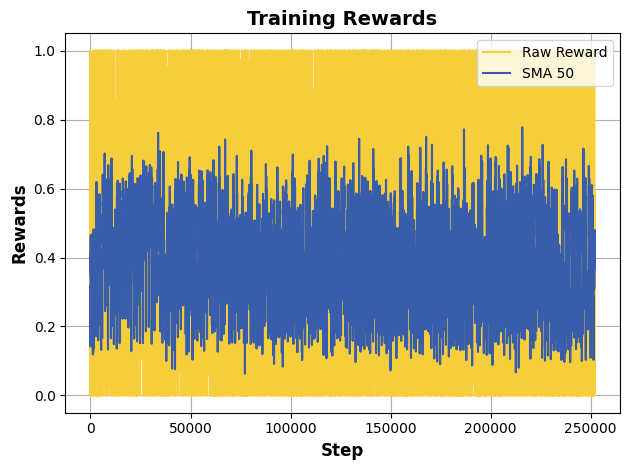

  Training PPO_10...
Step: 20000, Avg Reward: 0.40768295526504517, Max Reward: 1.0, Min Reward: 0.0
Step: 40000, Avg Reward: 0.41928622126579285, Max Reward: 1.0, Min Reward: 0.0
Step: 60000, Avg Reward: 0.3570188879966736, Max Reward: 1.0, Min Reward: 0.0
Step: 80000, Avg Reward: 0.3565286695957184, Max Reward: 1.0, Min Reward: 0.0
Step: 100000, Avg Reward: 0.33391323685646057, Max Reward: 1.0, Min Reward: 0.0
Step: 120000, Avg Reward: 0.3432813584804535, Max Reward: 1.0, Min Reward: 0.0
Step: 140000, Avg Reward: 0.3224055767059326, Max Reward: 1.0, Min Reward: 0.0
Step: 160000, Avg Reward: 0.3310246467590332, Max Reward: 1.0, Min Reward: 0.0
Step: 180000, Avg Reward: 0.33196747303009033, Max Reward: 1.0, Min Reward: 0.0
Step: 200000, Avg Reward: 0.32654163241386414, Max Reward: 1.0, Min Reward: 0.0
Step: 220000, Avg Reward: 0.3453173339366913, Max Reward: 1.0, Min Reward: 0.0
Step: 240000, Avg Reward: 0.3353423476219177, Max Reward: 1.0, Min Reward: 0.0
Training finished. Total rewar

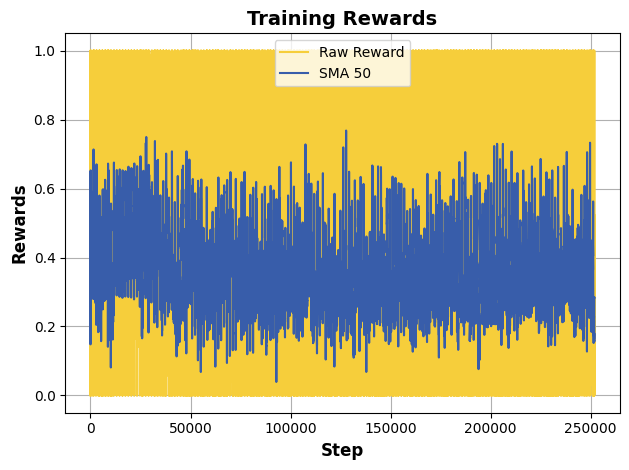

  Training PPO_15...
Step: 20000, Avg Reward: 0.3871888220310211, Max Reward: 1.0, Min Reward: 0.0
Step: 40000, Avg Reward: 0.40027952194213867, Max Reward: 1.0, Min Reward: 0.0
Step: 60000, Avg Reward: 0.45786216855049133, Max Reward: 1.0, Min Reward: 0.0
Step: 80000, Avg Reward: 0.4887484312057495, Max Reward: 1.0, Min Reward: 0.0
Step: 100000, Avg Reward: 0.4767463505268097, Max Reward: 1.0, Min Reward: 0.0
Step: 120000, Avg Reward: 0.4906376004219055, Max Reward: 1.0, Min Reward: 0.0
Step: 140000, Avg Reward: 0.49016639590263367, Max Reward: 1.0, Min Reward: 0.0
Step: 160000, Avg Reward: 0.4939281642436981, Max Reward: 1.0, Min Reward: 0.0
Step: 180000, Avg Reward: 0.464689701795578, Max Reward: 1.0, Min Reward: 0.0
Step: 200000, Avg Reward: 0.48377764225006104, Max Reward: 1.0, Min Reward: 0.0
Step: 220000, Avg Reward: 0.506081223487854, Max Reward: 1.0, Min Reward: 0.0
Step: 240000, Avg Reward: 0.48231440782546997, Max Reward: 1.0, Min Reward: 0.0
Training finished. Total rewards

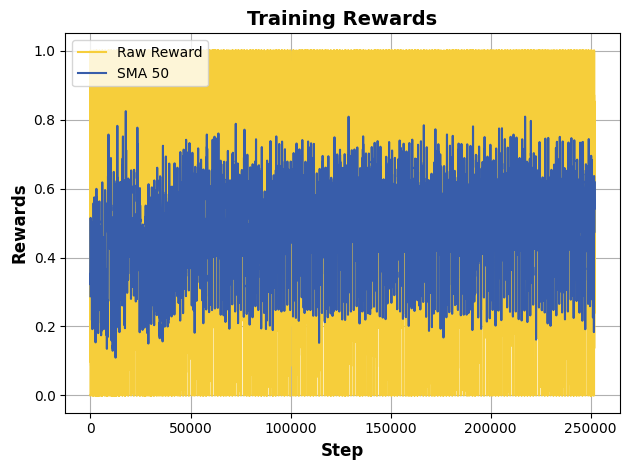

  Training PPO_20...
Step: 20000, Avg Reward: 0.4926483929157257, Max Reward: 1.0, Min Reward: 0.0
Step: 40000, Avg Reward: 0.4996275305747986, Max Reward: 1.0, Min Reward: 0.0
Step: 60000, Avg Reward: 0.4279532730579376, Max Reward: 1.0, Min Reward: 0.0
Step: 80000, Avg Reward: 0.4263356029987335, Max Reward: 1.0, Min Reward: 0.0
Step: 100000, Avg Reward: 0.426617830991745, Max Reward: 1.0, Min Reward: 0.0
Step: 120000, Avg Reward: 0.43294310569763184, Max Reward: 1.0, Min Reward: 0.0
Step: 140000, Avg Reward: 0.42391180992126465, Max Reward: 1.0, Min Reward: 0.0
Step: 160000, Avg Reward: 0.4765528738498688, Max Reward: 1.0, Min Reward: 0.0
Step: 180000, Avg Reward: 0.4496537744998932, Max Reward: 1.0, Min Reward: 0.0
Step: 200000, Avg Reward: 0.44986024498939514, Max Reward: 1.0, Min Reward: 0.0
Step: 220000, Avg Reward: 0.43235790729522705, Max Reward: 1.0, Min Reward: 0.0
Step: 240000, Avg Reward: 0.4501507878303528, Max Reward: 1.0, Min Reward: 0.0
Training finished. Total rewards

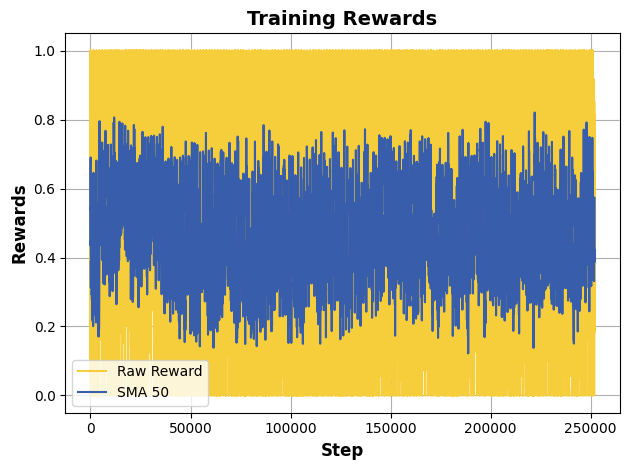

  Training PPO_25...
Step: 20000, Avg Reward: 0.37458792328834534, Max Reward: 1.0, Min Reward: 0.0
Step: 40000, Avg Reward: 0.431396484375, Max Reward: 1.0, Min Reward: 0.0
Step: 60000, Avg Reward: 0.4132193922996521, Max Reward: 1.0, Min Reward: 0.0
Step: 80000, Avg Reward: 0.42746835947036743, Max Reward: 1.0, Min Reward: 0.0
Step: 100000, Avg Reward: 0.4086369276046753, Max Reward: 1.0, Min Reward: 0.0
Step: 120000, Avg Reward: 0.42978256940841675, Max Reward: 1.0, Min Reward: 0.0
Step: 140000, Avg Reward: 0.44337406754493713, Max Reward: 1.0, Min Reward: 0.0
Step: 160000, Avg Reward: 0.42474374175071716, Max Reward: 1.0, Min Reward: 0.0
Step: 180000, Avg Reward: 0.4380190372467041, Max Reward: 1.0, Min Reward: 0.0
Step: 200000, Avg Reward: 0.4574476182460785, Max Reward: 1.0, Min Reward: 0.0
Step: 220000, Avg Reward: 0.4583801329135895, Max Reward: 1.0, Min Reward: 0.0
Step: 240000, Avg Reward: 0.4601317346096039, Max Reward: 1.0, Min Reward: 0.0
Training finished. Total rewards: 

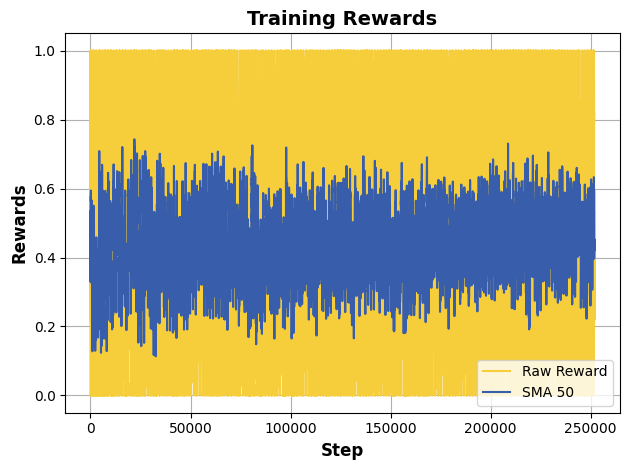


Training A2C models...
  Training A2C_5...
Step: 20000, Avg Reward: 0.43906503915786743, Max Reward: 1.0, Min Reward: 0.0
Step: 40000, Avg Reward: 0.4373237192630768, Max Reward: 1.0, Min Reward: 0.0
Step: 60000, Avg Reward: 0.43794551491737366, Max Reward: 1.0, Min Reward: 0.0
Step: 80000, Avg Reward: 0.43501016497612, Max Reward: 1.0, Min Reward: 0.0
Step: 100000, Avg Reward: 0.43171074986457825, Max Reward: 1.0, Min Reward: 0.0
Step: 120000, Avg Reward: 0.43515917658805847, Max Reward: 1.0, Min Reward: 0.0
Step: 140000, Avg Reward: 0.4369890093803406, Max Reward: 1.0, Min Reward: 0.0
Step: 160000, Avg Reward: 0.43347489833831787, Max Reward: 1.0, Min Reward: 0.0
Step: 180000, Avg Reward: 0.43880313634872437, Max Reward: 1.0, Min Reward: 0.0
Step: 200000, Avg Reward: 0.43897539377212524, Max Reward: 1.0, Min Reward: 0.0
Step: 220000, Avg Reward: 0.43847280740737915, Max Reward: 1.0, Min Reward: 0.0
Step: 240000, Avg Reward: 0.43867963552474976, Max Reward: 1.0, Min Reward: 0.0
Train

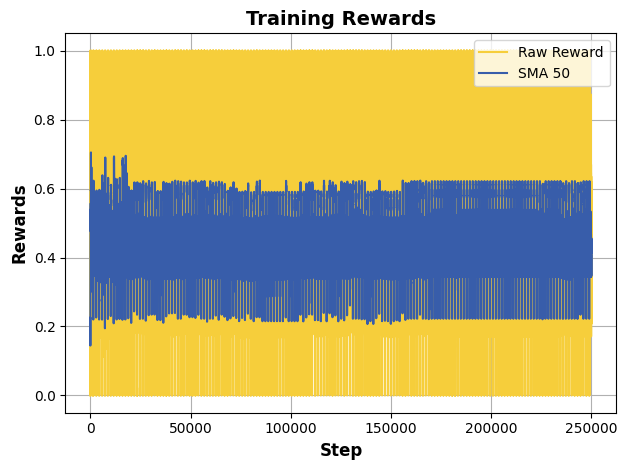

  Training A2C_10...
Step: 20000, Avg Reward: 0.47392016649246216, Max Reward: 1.0, Min Reward: 0.0
Step: 40000, Avg Reward: 0.446196585893631, Max Reward: 1.0, Min Reward: 0.0
Step: 60000, Avg Reward: 0.43746674060821533, Max Reward: 1.0, Min Reward: 0.0
Step: 80000, Avg Reward: 0.4276764690876007, Max Reward: 1.0, Min Reward: 0.0
Step: 100000, Avg Reward: 0.4280756413936615, Max Reward: 1.0, Min Reward: 0.0
Step: 120000, Avg Reward: 0.43533119559288025, Max Reward: 1.0, Min Reward: 0.0
Step: 140000, Avg Reward: 0.45208480954170227, Max Reward: 1.0, Min Reward: 0.0
Step: 160000, Avg Reward: 0.42558085918426514, Max Reward: 1.0, Min Reward: 0.0
Step: 180000, Avg Reward: 0.4142630994319916, Max Reward: 1.0, Min Reward: 0.0
Step: 200000, Avg Reward: 0.42830127477645874, Max Reward: 1.0, Min Reward: 0.0
Step: 220000, Avg Reward: 0.41452330350875854, Max Reward: 1.0, Min Reward: 0.0
Step: 240000, Avg Reward: 0.4045034348964691, Max Reward: 1.0, Min Reward: 0.0
Training finished. Total rewa

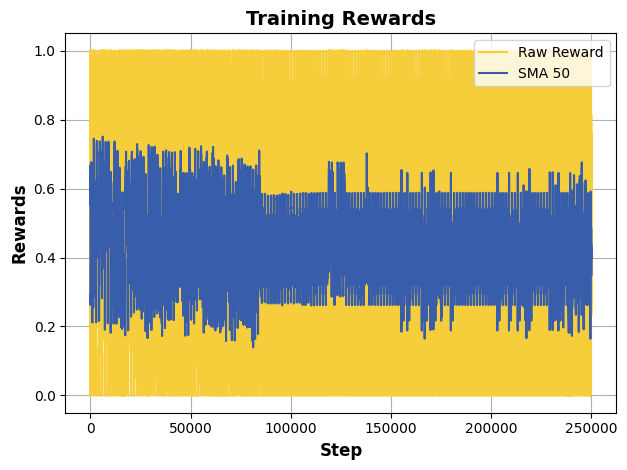

  Training A2C_15...
Step: 20000, Avg Reward: 0.49042022228240967, Max Reward: 1.0, Min Reward: 0.0
Step: 40000, Avg Reward: 0.4451463520526886, Max Reward: 1.0, Min Reward: 0.0
Step: 60000, Avg Reward: 0.4303344786167145, Max Reward: 1.0, Min Reward: 0.0
Step: 80000, Avg Reward: 0.4301919937133789, Max Reward: 1.0, Min Reward: 0.0
Step: 100000, Avg Reward: 0.42775946855545044, Max Reward: 1.0, Min Reward: 0.0
Step: 120000, Avg Reward: 0.42490333318710327, Max Reward: 1.0, Min Reward: 0.0
Step: 140000, Avg Reward: 0.4232994019985199, Max Reward: 1.0, Min Reward: 0.0
Step: 160000, Avg Reward: 0.4285924434661865, Max Reward: 1.0, Min Reward: 0.0
Step: 180000, Avg Reward: 0.4287585914134979, Max Reward: 1.0, Min Reward: 0.0
Step: 200000, Avg Reward: 0.42773741483688354, Max Reward: 1.0, Min Reward: 0.0
Step: 220000, Avg Reward: 0.42869165539741516, Max Reward: 1.0, Min Reward: 0.0
Step: 240000, Avg Reward: 0.4249645471572876, Max Reward: 1.0, Min Reward: 0.0
Training finished. Total rewar

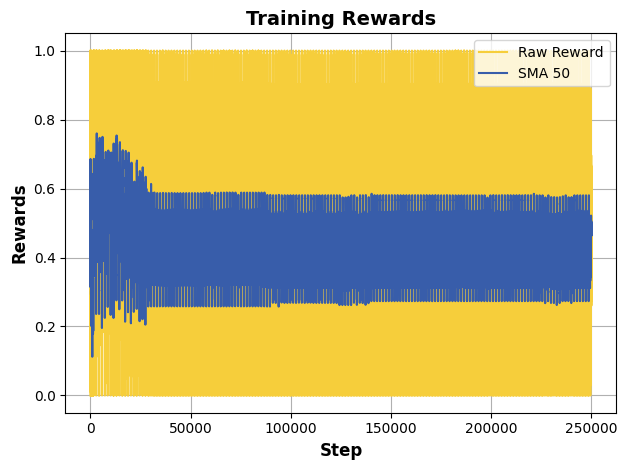

  Training A2C_20...
Step: 20000, Avg Reward: 0.43397364020347595, Max Reward: 1.0, Min Reward: 0.0
Step: 40000, Avg Reward: 0.43667173385620117, Max Reward: 1.0, Min Reward: 0.0
Step: 60000, Avg Reward: 0.48198914527893066, Max Reward: 1.0, Min Reward: 0.0
Step: 80000, Avg Reward: 0.4389054775238037, Max Reward: 1.0, Min Reward: 0.0
Step: 100000, Avg Reward: 0.43880948424339294, Max Reward: 1.0, Min Reward: 0.0
Step: 120000, Avg Reward: 0.43780937790870667, Max Reward: 1.0, Min Reward: 0.0
Step: 140000, Avg Reward: 0.43794041872024536, Max Reward: 1.0, Min Reward: 0.0
Step: 160000, Avg Reward: 0.43604791164398193, Max Reward: 1.0, Min Reward: 0.0
Step: 180000, Avg Reward: 0.4341607391834259, Max Reward: 1.0, Min Reward: 0.0
Step: 200000, Avg Reward: 0.4333798885345459, Max Reward: 1.0, Min Reward: 0.0
Step: 220000, Avg Reward: 0.43340054154396057, Max Reward: 1.0, Min Reward: 0.0
Step: 240000, Avg Reward: 0.4330579936504364, Max Reward: 1.0, Min Reward: 0.0
Training finished. Total re

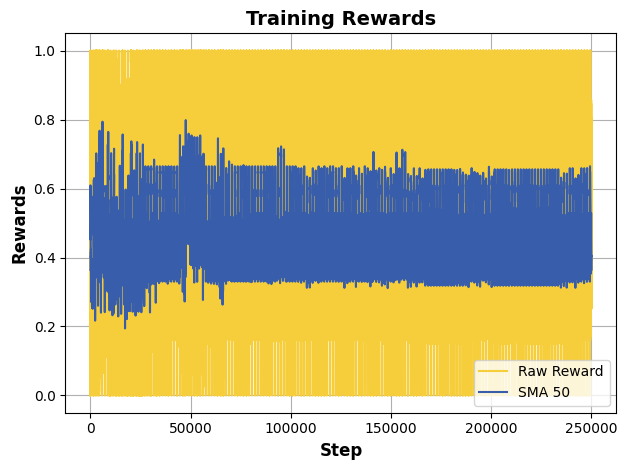

  Training A2C_25...
Step: 20000, Avg Reward: 0.42934849858283997, Max Reward: 1.0, Min Reward: 0.0
Step: 40000, Avg Reward: 0.41581645607948303, Max Reward: 1.0, Min Reward: 0.0
Step: 60000, Avg Reward: 0.4349287152290344, Max Reward: 1.0, Min Reward: 0.0
Step: 80000, Avg Reward: 0.4286821782588959, Max Reward: 1.0, Min Reward: 0.0
Step: 100000, Avg Reward: 0.47230011224746704, Max Reward: 1.0, Min Reward: 0.0
Step: 120000, Avg Reward: 0.4435621201992035, Max Reward: 1.0, Min Reward: 0.0
Step: 140000, Avg Reward: 0.4180375039577484, Max Reward: 1.0, Min Reward: 0.0
Step: 160000, Avg Reward: 0.43091124296188354, Max Reward: 1.0, Min Reward: 0.0
Step: 180000, Avg Reward: 0.4324086010456085, Max Reward: 1.0, Min Reward: 0.0
Step: 200000, Avg Reward: 0.43612366914749146, Max Reward: 1.0, Min Reward: 0.0
Step: 220000, Avg Reward: 0.4355236291885376, Max Reward: 1.0, Min Reward: 0.0
Step: 240000, Avg Reward: 0.4295448660850525, Max Reward: 1.0, Min Reward: 0.0
Training finished. Total rewar

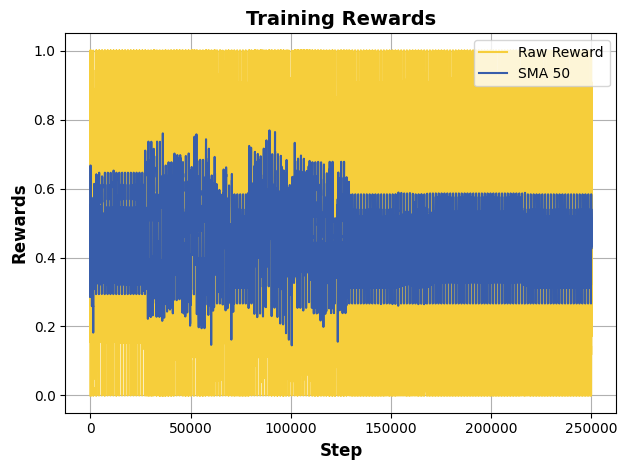


Training RecurrentPPO models...
  Training RPPO_5...
Step: 20000, Avg Reward: 0.43787989020347595, Max Reward: 1.0, Min Reward: 0.0
Step: 40000, Avg Reward: 0.4978373050689697, Max Reward: 1.0, Min Reward: 0.0
Step: 60000, Avg Reward: 0.43934154510498047, Max Reward: 1.0, Min Reward: 0.0
Step: 80000, Avg Reward: 0.47967422008514404, Max Reward: 1.0, Min Reward: 0.0
Step: 100000, Avg Reward: 0.46662211418151855, Max Reward: 1.0, Min Reward: 0.0
Step: 120000, Avg Reward: 0.4699687063694, Max Reward: 1.0, Min Reward: 0.0
Step: 140000, Avg Reward: 0.480609655380249, Max Reward: 1.0, Min Reward: 0.0
Step: 160000, Avg Reward: 0.5046612620353699, Max Reward: 1.0, Min Reward: 0.0
Step: 180000, Avg Reward: 0.49396851658821106, Max Reward: 1.0, Min Reward: 0.0
Step: 200000, Avg Reward: 0.5072686076164246, Max Reward: 1.0, Min Reward: 0.0
Step: 220000, Avg Reward: 0.5091552734375, Max Reward: 1.0, Min Reward: 0.0
Step: 240000, Avg Reward: 0.5092577338218689, Max Reward: 1.0, Min Reward: 0.0
Trai

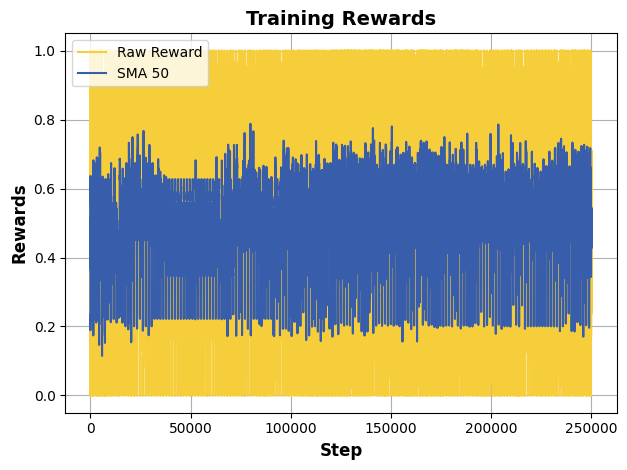

  Training RPPO_10...
Step: 20000, Avg Reward: 0.471774697303772, Max Reward: 1.0, Min Reward: 0.0
Step: 40000, Avg Reward: 0.5166976451873779, Max Reward: 1.0, Min Reward: 0.0
Step: 60000, Avg Reward: 0.5080583691596985, Max Reward: 1.0, Min Reward: 0.0
Step: 80000, Avg Reward: 0.5048255324363708, Max Reward: 1.0, Min Reward: 0.0
Step: 100000, Avg Reward: 0.5162464380264282, Max Reward: 1.0, Min Reward: 0.0
Step: 120000, Avg Reward: 0.49111029505729675, Max Reward: 1.0, Min Reward: 0.0
Step: 140000, Avg Reward: 0.5167859792709351, Max Reward: 1.0, Min Reward: 0.0
Step: 160000, Avg Reward: 0.4378194808959961, Max Reward: 1.0, Min Reward: 0.0
Step: 180000, Avg Reward: 0.41428226232528687, Max Reward: 1.0, Min Reward: 0.0
Step: 200000, Avg Reward: 0.4426683485507965, Max Reward: 1.0, Min Reward: 0.0
Step: 220000, Avg Reward: 0.4926077723503113, Max Reward: 1.0, Min Reward: 0.0
Step: 240000, Avg Reward: 0.44443202018737793, Max Reward: 1.0, Min Reward: 0.0
Training finished. Total rewards

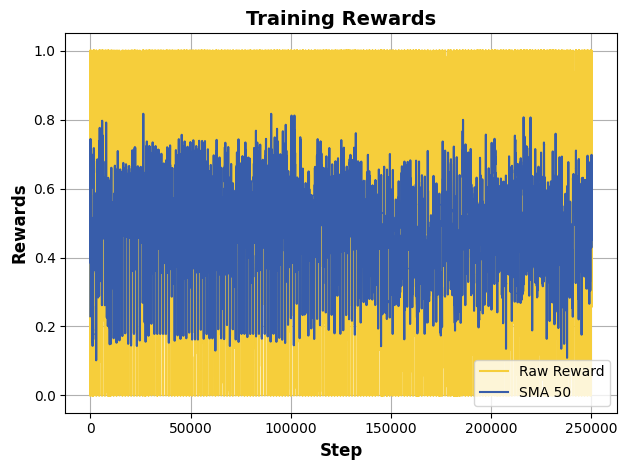

  Training RPPO_15...
Step: 20000, Avg Reward: 0.41491493582725525, Max Reward: 1.0, Min Reward: 0.0
Step: 40000, Avg Reward: 0.4320986270904541, Max Reward: 1.0, Min Reward: 0.0
Step: 60000, Avg Reward: 0.43113037943840027, Max Reward: 1.0, Min Reward: 0.0
Step: 80000, Avg Reward: 0.431537002325058, Max Reward: 1.0, Min Reward: 0.0
Step: 100000, Avg Reward: 0.4273257851600647, Max Reward: 1.0, Min Reward: 0.0
Step: 120000, Avg Reward: 0.4229646921157837, Max Reward: 1.0, Min Reward: 0.0
Step: 140000, Avg Reward: 0.37991997599601746, Max Reward: 1.0, Min Reward: 0.0
Step: 160000, Avg Reward: 0.35166385769844055, Max Reward: 1.0, Min Reward: 0.0
Step: 180000, Avg Reward: 0.369920939207077, Max Reward: 1.0, Min Reward: 0.0
Step: 200000, Avg Reward: 0.3473990857601166, Max Reward: 1.0, Min Reward: 0.0
Step: 220000, Avg Reward: 0.353475958108902, Max Reward: 1.0, Min Reward: 0.0
Step: 240000, Avg Reward: 0.3584113121032715, Max Reward: 1.0, Min Reward: 0.0
Training finished. Total rewards:

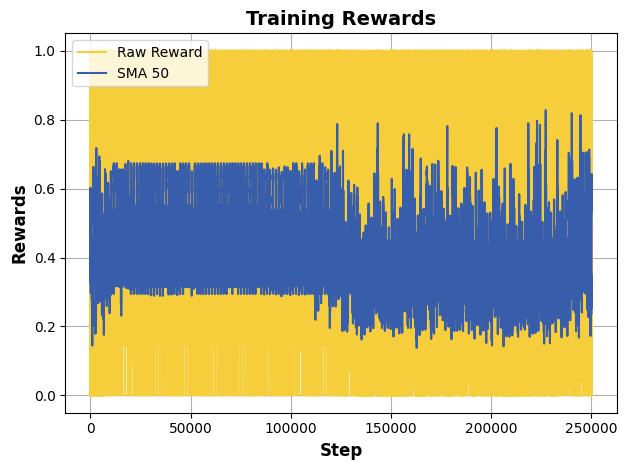

  Training RPPO_20...
Step: 20000, Avg Reward: 0.4378053843975067, Max Reward: 1.0, Min Reward: 0.0
Step: 40000, Avg Reward: 0.44143185019493103, Max Reward: 1.0, Min Reward: 0.0
Step: 60000, Avg Reward: 0.4298557639122009, Max Reward: 1.0, Min Reward: 0.0
Step: 80000, Avg Reward: 0.42638862133026123, Max Reward: 1.0, Min Reward: 0.0
Step: 100000, Avg Reward: 0.4252595603466034, Max Reward: 1.0, Min Reward: 0.0
Step: 120000, Avg Reward: 0.42524024844169617, Max Reward: 1.0, Min Reward: 0.0
Step: 140000, Avg Reward: 0.421252965927124, Max Reward: 1.0, Min Reward: 0.0
Step: 160000, Avg Reward: 0.42669862508773804, Max Reward: 1.0, Min Reward: 0.0
Step: 180000, Avg Reward: 0.43652498722076416, Max Reward: 1.0, Min Reward: 0.0


In [ ]:
def main():
    # Stock data configuration
    STOCK_LIST_VN = ['FPT', 'VCB', 'VIC', 'GAS', 'VHM', 'BID', 'MBB', 'HVN', 'HPG', 'GVR', 'VNM', 'SSI', 'GEX', 'ACB']
    STOCK_LIST_US = ['AXP', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HON', 'IBM', 'INTC', 'JPM', 'MSFT', 'NKE', 'GOOGL', 'AMZN', 'WMT', 'NVDA']
    STOCK_LIST_CN = ['BABA', 'JD', 'PDD', 'NTES', 'BIDU', 'NIO', 'XPEV', 'LI']
    STOCK_LIST_GLOBAL = STOCK_LIST_US + STOCK_LIST_CN + ['GLD'] # Gold as a reference asset

    COUNTRY_TO_STOCKS = {
        'USA': STOCK_LIST_US,
        'China': STOCK_LIST_CN,
        'Vietnam': STOCK_LIST_VN
    }
    
    # Date ranges
    TRAIN_START_DATE = '2020-01-01'
    TRAIN_END_DATE = '2024-01-01'
    TEST_START_DATE = '2024-01-01'
    TEST_END_DATE = '2025-03-15'
    
    print(f"Number of stocks using: {len(STOCK_LIST_VN) + len(STOCK_LIST_GLOBAL) - 1}") # Gold not counted
    
    # Macroeconomic data
    # Combination of Trading Economics website and https://www.stats.gov.cn/english/PressRelease/202101/t20210112_1812282.html for China CPI
    # Data take by end of the month (except GDP (end of the year)) then fill in the gaps evenly
    eco_data = pd.read_csv(
        "economic_indicators.csv",
        header=[0, 1],
        index_col=0, 
        parse_dates=True 
    )
    
    for col in eco_data.columns:
        eco_data[col] = pd.to_numeric(eco_data[col])
    
    eco_data = fill_price_gaps_evenly(eco_data)
    
    # News sentiment data
    # Extracted from Yahoo Finance, CafeF, Alpha Vantage, etc.
    news_sentiment = pd.read_csv("processed_news_sentiment.csv", parse_dates=["datetime"])

    # Filter news sentiment data for training period
    train_news_sentiment = news_sentiment[
        (news_sentiment['datetime'] >= TRAIN_START_DATE) & 
        (news_sentiment['datetime'] <= TRAIN_END_DATE)
    ]
    
    # Process training data
    print("\n--- PROCESSING TRAINING DATA ---")
    
    # Fetch stock data
    print("Fetching train stock data...")
    train_stock_data = fetch_stock_data(
        STOCK_LIST_VN, 
        STOCK_LIST_GLOBAL, 
        TRAIN_START_DATE, 
        TRAIN_END_DATE
    )
    
    print("Fetching train economic indicators and news sentiment...")
    train_econ_data = eco_data.loc[TRAIN_START_DATE:TRAIN_END_DATE]
    
    train_data = merge_data_sources(
        [train_stock_data, train_econ_data],
        output_file="train_data_complete.csv",
        country_to_stocks=COUNTRY_TO_STOCKS,
        news_sentiment_data=train_news_sentiment
    )
    
    train_data = train_data.drop_duplicates()
    
    print("\n--- PROCESSING TEST DATA ---")
    
    print("Fetching test stock data...")
    test_stock_data = fetch_stock_data(
        STOCK_LIST_VN, 
        STOCK_LIST_GLOBAL, 
        TEST_START_DATE, 
        TEST_END_DATE
    )
    
    test_econ_data = eco_data.loc[TEST_START_DATE:TEST_END_DATE]
    
    # Filter news sentiment data for test period
    test_news_sentiment = news_sentiment[
        (news_sentiment['datetime'] >= TEST_START_DATE) & 
        (news_sentiment['datetime'] <= TEST_END_DATE)
    ]
    
    print("Fetching test economic indicators and news sentiment...")
    test_data = merge_data_sources(
        [test_stock_data, test_econ_data],
        output_file="test_data_complete.csv",
        country_to_stocks=COUNTRY_TO_STOCKS,
        news_sentiment_data=test_news_sentiment
    )
    
    test_data = test_data.drop_duplicates()
    
    # print("\nTrain data shape:", train_data.shape)
    print("Test data shape:", test_data.shape)
    print("\nRange dates:")
    # print("Train data range:", train_data.index.min(), "to", train_data.index.max())
    print("Test data range:", test_data.index.min(), "to", test_data.index.max())
    print("\nData processing completed successfully.")
    
    # Create directories
    os.makedirs("models", exist_ok=True)
    os.makedirs("logs", exist_ok=True)
    os.makedirs("plots", exist_ok=True)
    
    # Define model classes and their hyperparameter lists
    models_to_train = [
        (PPO, HYPERPARAMS_PPO), # 250000 timesteps
        (A2C, HYPERPARAMS_A2C),
        (RecurrentPPO, HYPERPARAMS_RPPO),
        (TRPO, HYPERPARAMS_TRPO),
        # (SAC, HYPERPARAMS_SAC), # 40000 timesteps
        # (TD3, HYPERPARAMS_TD3),
    ]
    
    model_paths = []
    models_info = {}
    
    # Train all models with different hyperparameters
    for model_class, hyperparams_list in models_to_train:
        model_type = model_class.__name__
        print(f"\nTraining {model_type} models...")
        
        for params in hyperparams_list:
            for win_size in WINDOW_SIZE:
                model_name = params["name"]
                print(f"  Training {model_name}_{win_size}...")
    
                # Create a copy of params to avoid modifying the original
                params_copy = params.copy()
    
                # Train model
                model_path = train_model(
                    model_class=model_class,
                    params=params_copy,
                    data=train_data,
                    initial_balance=5000,
                    max_shares=10000,
                    trade_max=100,
                    timesteps=250000,
                    window_size=win_size
                )
    
                model_paths.append(model_path)
                models_info[model_path] = {
                    "model_class": model_class,
                    "window_size": win_size
                }
    
    # model_paths = [
    #     "models/PPO/PPO_5.zip",
    #     "models/PPO/PPO_10.zip",
    #     "models/PPO/PPO_15.zip",
    #     "models/PPO/PPO_20.zip",
    #     "models/PPO/PPO_25.zip",
    #     "models/A2C/A2C_5.zip",
    #     "models/A2C/A2C_10.zip",
    #     "models/A2C/A2C_15.zip",
    #     "models/A2C/A2C_20.zip",
    #     "models/A2C/A2C_25.zip",
    #     "models/RPPO/RPPO_5.zip",
    #     "models/RPPO/RPPO_10.zip",
    #     "models/RPPO/RPPO_15.zip",
    #     "models/RPPO/RPPO_20.zip",
    #     "models/RPPO/RPPO_25.zip",
    #     "models/TRPO/TRPO_5.zip",
    #     "models/TRPO/TRPO_10.zip",
    #     "models/TRPO/TRPO_15.zip",
    #     "models/TRPO/TRPO_20.zip",
    #     "models/TRPO/TRPO_25.zip",
    #     "models/SAC/SAC_5.zip",
    #     "models/SAC/SAC_10.zip",
    #     "models/SAC/SAC_15.zip",
    #     "models/SAC/SAC_20.zip",
    #     "models/SAC/SAC_25.zip",
    #     "models/TD3/TD3_5.zip",
    #     "models/TD3/TD3_10.zip",
    #     "models/TD3/TD3_15.zip",
    #     "models/TD3/TD3_20.zip",
    #     "models/TD3/TD3_25.zip",
    # ]

    # models_info = {
    #     "models/PPO/PPO_5.zip": {"model_class": PPO, "window_size": 5},
    #     "models/PPO/PPO_10.zip": {"model_class": PPO, "window_size": 10},
    #     "models/PPO/PPO_15.zip": {"model_class": PPO, "window_size": 15},
    #     "models/PPO/PPO_20.zip": {"model_class": PPO, "window_size": 20},
    #     "models/PPO/PPO_25.zip": {"model_class": PPO, "window_size": 25},
    #     "models/A2C/A2C_5.zip": {"model_class": A2C, "window_size": 5},
    #     "models/A2C/A2C_10.zip": {"model_class": A2C, "window_size": 10},
    #     "models/A2C/A2C_15.zip": {"model_class": A2C, "window_size": 15},
    #     "models/A2C/A2C_20.zip": {"model_class": A2C, "window_size": 20},
    #     "models/A2C/A2C_25.zip": {"model_class": A2C, "window_size": 25},
    #     "models/RPPO/RPPO_5.zip": {"model_class": RecurrentPPO, "window_size": 5},
    #     "models/RPPO/RPPO_10.zip": {"model_class": RecurrentPPO, "window_size": 10},
    #     "models/RPPO/RPPO_15.zip": {"model_class": RecurrentPPO, "window_size": 15},
    #     "models/RPPO/RPPO_20.zip": {"model_class": RecurrentPPO, "window_size": 20},
    #     "models/RPPO/RPPO_25.zip": {"model_class": RecurrentPPO, "window_size": 25},
    #     "models/TRPO/TRPO_5.zip": {"model_class": TRPO, "window_size": 5},
    #     "models/TRPO/TRPO_10.zip": {"model_class": TRPO, "window_size": 10},
    #     "models/TRPO/TRPO_15.zip": {"model_class": TRPO, "window_size": 15},
    #     "models/TRPO/TRPO_20.zip": {"model_class": TRPO, "window_size": 20},
    #     "models/TRPO/TRPO_25.zip": {"model_class": TRPO, "window_size": 25},
    #     "models/SAC/SAC_5.zip": {"model_class": SAC, "window_size": 5},
    #     "models/SAC/SAC_10.zip": {"model_class": SAC, "window_size": 10},
    #     "models/SAC/SAC_15.zip": {"model_class": SAC, "window_size": 15},
    #     "models/SAC/SAC_20.zip": {"model_class": SAC, "window_size": 20},
    #     "models/SAC/SAC_25.zip": {"model_class": SAC, "window_size": 25},
    #     "models/TD3/TD3_5.zip": {"model_class": TD3, "window_size": 5},
    #     "models/TD3/TD3_10.zip": {"model_class": TD3, "window_size": 10},
    #     "models/TD3/TD3_15.zip": {"model_class": TD3, "window_size": 15},
    #     "models/TD3/TD3_20.zip": {"model_class": TD3, "window_size": 20},
    #     "models/TD3/TD3_25.zip": {"model_class": TD3, "window_size": 25},
    # }
    
    results = run_evaluation(model_paths, models_info, test_data)
    
    # Generate visualizations
    plot_portfolio_performance(results)
    generate_results_dashboard(results)
    
    print("Evaluation and visualization completed!")

if __name__ == "__main__":
    main()